In [1]:
from scipy.io import wavfile 
capstone_dir = "/Users/ninismacbook/other_docs/Y4S1+S2/capstone" 
import matplotlib.pyplot as plt; import numpy as np; import pandas as pd ; import librosa
import librosa.display # Must have
from dtw import dtw; import scipy.stats
import math

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Everything together - 13 MFCCs

In [2]:
def normalize(mfcc):
    
    matrix = np.zeros((mfcc.shape))
    
    for i in range(mfcc.shape[0]):
        array = mfcc[i, :]
        mean = np.mean(array)
        sd = np.std(array)
        
        for j in range(mfcc.shape[1]):
            new_val = (mfcc[i, j]-mean)/sd
            if new_val > 2:
                new_val == 2
            if new_val < -2:
                new_val == -2
            matrix[i, j] = new_val/5 + 0.5
    return matrix

# print(normalize(np.array([[-3, -2, -1], [3, 2, 3]])))

In [3]:
# deviation function
def deviation(rho, theta):
    dev = 0
    if rho >= theta and rho <= math.pi/2:
        dev = (rho-theta)/(math.pi/2-theta)
    else:
        dev = (theta - rho)/theta
    return dev

In [4]:
def remove_short_pauses(speech_array, min_pause_len_s, mfcc_len_s): # filter out pauses shorter than min_pause_len_s in speech array
    
    sp_transitions = []     
    for s in range(len(speech_array)-1):
        if s > 0 and s < len(speech_array):
            if speech_array[s] == 0 and speech_array[s+1] == 1:
                sp_transitions.append(s)
            if speech_array[s] == 1 and speech_array[s+1] == 0:
                sp_transitions.append(s)
    
    for t in range(len(sp_transitions)-1):
        if (sp_transitions[t+1] - sp_transitions[t])*mfcc_len_s < min_pause_len_s:
            speech_array[sp_transitions[t]:sp_transitions[t+1]] = [1]*(sp_transitions[t+1]-sp_transitions[t])
            
    return speech_array

In [5]:
def speech(smooth_query, original_query, seg1_1, seg1_2, samplerate, frame_per_window, **kwargs):

    input_min_amp = kwargs.get('input_min_amp', None)
    input_min_pause = kwargs.get('input_min_pause', None)    # unit = ms
    
    if input_min_amp == None:
        abs_q = np.abs(original_query[int(samplerate*0.5): int(samplerate*0.5 + frame_per_window)])    
        default_min_amp = np.max(abs_q)
        print('Default amplitude threshold: ', default_min_amp)
        min_amp = default_min_amp
    else:
        min_amp = input_min_amp
    
    indices = []
    max_am = max(np.abs(original_query))    
    result = []                
    result.append(0) # the first frame is always pause
    
    for i in range(1, len(smooth_query)):    

        # Since we scaled the amplitudes, we need to multiply the smoothened amplitude value by the normalization constant
        if np.abs(smooth_query[i]) > min_amp:
            
            if result[-1] == 0: # if previous frame is pause, this index marks start of speech
                indices.append(i)
            result.append(1)
            
        else:
            if result[-1] == 1: # if previous frame is speech, this index marks end of speech
                indices.append(i)
            result.append(0)
    
    min_pause_len = input_min_pause * samplerate /1000

    # filter out pauses whose length is shorter than input_min_pause
    for p in range(1, len(indices)-1, 2):
        if indices[p+1] - indices[p] < min_pause_len:

            # Update result: change the pauses that are too short to speech
            result[indices[p] : indices[p+1]] = [1] * (indices[p+1] - indices[p])
            
            # Update the indices to -1, and remove all -1 index in the end
            indices[p+1] = -1
            indices[p] = -1

    indices = [seg for seg in indices if seg != -1]            

    return result, min_amp

In [6]:
def return_common_seg(alignment, sr1, speech_x, time1, time2, min_pause_len_s, mfcc_len_s):
    
    xs = alignment.index1
    ys = alignment.index2
    
    # For 1 point in the warping path x, y
    # xs[i] = index of the point in the original query that dtw uses to align x
    # ys[i] = index of the point in the original reference query that dtw uses to align y                      
    # length of path = len(path[0]) = len(path[1])

    common_seg = {} # store the list of speech and pause segments
    common_seg_dict = {}
    path_indices = []

    seg_index_x = []
    seg_index_y = []
    
    len_x = len(speech_x)
    
    seg_index = 0

    
    for i in range(len(speech_x)-1):  # get segments in y based on alignment curve
        if speech_x[i] != speech_x[i+1]:
            if speech_x[i] == 0:                #speech segment starts
                seg = "speech"
            if speech_x[i] == 1:                # pause segment starts
                seg = "pause"

            seg_index_x = int(i/len_x*max(alignment.index1))       #i/len_x = the proportion in speech_x. max(alignment.index1) gives the total number of mfcc in x
            timestamps_x = seg_index_x*mfcc_len_s+time1[0]

            y_index = np.where(alignment.index1 == seg_index_x)    
            seg_index_y = alignment.index2[y_index][0]
        
            timestamps_y = seg_index_y*mfcc_len_s+time2[0]
            common_seg_dict[seg_index+1] = [seg, timestamps_x, timestamps_y]
            
            seg_index = seg_index + 1  
            path_indices.append(y_index[0][0])
    
    path_indices = np.squeeze(path_indices)
    
    return seg_index_x, seg_index_y, common_seg_dict, path_indices

In [7]:
def calc_path_len(alignment):

    counter = 0
    for i in alignment.stepsTaken:
        if i == 1:
            counter = counter + 1
    return counter*math.sqrt(2)+len(alignment.stepsTaken)-counter

In [8]:
def plot_all_mfccs(mfcc1_normal, mfcc2_normal):
    time1 = np.linspace(0, mfcc1_normal.shape[1], num = mfcc1_normal.shape[1])   
    plt.figure(figsize=(10,3))
    for i in mfcc1_normal:
        plt.plot(time1, i);   
    
    time1 = np.linspace(0, mfcc2_normal.shape[1], num = mfcc2_normal.shape[1])
    plt.figure(figsize=(10,3))
    for i in mfcc2_normal:
        plt.plot(time1, i);   

In [9]:
def plot_amplitude_subplots(fragment_x, fragment_y, seg1_1, seg1_2, speech_x, smooth_x, seg2_1, seg2_2, min_amp_x, timelst1, timelst2, common_seg_dict):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
    fig.set_size_inches(20, 8)

    time = np.linspace(seg1_1, seg1_2, num = len(fragment_x))
    xticks = np.linspace(seg1_1, seg1_2, num = 20)
    
    ax1.plot(time, fragment_x)
    ax1.set_xticks(xticks) 
    if timelst1:
        for t in timelst1:
                ax1.axvline(t, color = 'black', ymin=0, ymax=1, linewidth=2)        
    
    ax2.plot(time, smooth_x)
    ax2.set_xticks(xticks)
    ax2.axhline(y = min_amp_x)          
    ax3.plot(time, speech_x)
    ax3.set_xticks(xticks)

    time = np.linspace(seg2_1, seg2_2, num = len(fragment_y))
    xticks = np.linspace(seg2_1, seg2_2, num = 20)
    
    ax4.plot(time, fragment_y)
    if timelst2:
            for t in timelst2:
                    ax4.axvline(t, color = 'black', ymin=0, ymax=1, linewidth=2)       
    ax4.set_xticks(xticks) 
    

    ax5.plot(time, fragment_y)
    ax5.set_xticks(xticks)      

    color_counter = 0
    for seg in list(common_seg_dict.values()):

        if color_counter % 2 == 0:
            c = 'red'
        else:
            c = 'green'

        ax3.axvline(seg[1], color = c, ymin=0, ymax=1, linewidth=4)   
        ax5.axvline(seg[2], color = c, ymin=0, ymax=1, linewidth=4)    
                        
        color_counter = color_counter + 1
        

In [10]:
def create_smooth_x(fragment_x, frame_per_window):
    smooth_x = [] # Store smoothened sample array    
    for i in range(len(fragment_x)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (len(fragment_x) - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = len(fragment_x)
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        num = np.mean(np.abs(fragment_x[int(i1) : int(i2)]))
        smooth_x.append(num) 
    return smooth_x

In [11]:
def plot_seg_and_alignment(timelst1, timelst2, alignment, seg1_1, seg1_2, sr1, seg2_1, seg2_2, sr2, hop_len_in_s):
    if timelst1 and timelst2:              # plot where the segments are on the bigger alignment curve plot
        plt.figure(figsize=(15, 3))
        plt.plot(alignment.index1, alignment.index2)
        
        time1_2 = (np.array(timelst1) - seg1_1)*sr1/int(hop_len_in_s*sr1)
        time2_2 = (np.array(timelst2) - seg2_1)*sr2/int(hop_len_in_s*sr2)

        colors = ['red', 'g', 'b', 'm', 'brown', '#d89743', 'grey', 'c', 'orange', 'g', 'b', 'm', 'red']

        for i in range(len(time1_2)):
            x_axis, y_axis = time1_2[i], time2_2[i]
            plt.axvline(x_axis, color = colors[i])
            plt.hlines(y_axis, 0, x_axis+10, color = colors[i]) 

In [12]:
def plot_each_mfcc(num_of_mfcc, mfcc1_normal, mfcc2_normal, alignment):
    for k in range(num_of_mfcc):        
        plot_x = []
        plot_y = []

        for i in range(len(alignment.index1)):
            plot_x.append(mfcc1_normal.T[alignment.index1[i]][k])
            plot_y.append(mfcc2_normal.T[alignment.index2[i]][k])

        plt.subplots(1, 1) 
        plt.scatter(plot_x, plot_y, color = 'black')
        plt.title(label= 'MFCC ' + str(k+1) + '. Pearson r = %3.2f' % scipy.stats.pearsonr(plot_x, plot_y)[0])

In [13]:
def stretch(alignment, seg_index_x, seg_index_y, common_seg_dict, path_indices, alpha):
    
#     theta = math.atan(alignment.M/alignment.N)  # angle of diagonal = length of y axis over length of x axis
    theta = math.atan(1)
    
    overall_stretch = 0
    overall_arclen = 0
    
    for s in range(0, len(path_indices)-1):     # calculate stretch in each common segment

        xs = alignment.index1[path_indices[s]:path_indices[s+1]]
        ys = alignment.index2[path_indices[s]:path_indices[s+1]]

        stretch = 0
        arclen = 0            

        for i in range(0, len(xs)-1):
            
            if i % alpha == 0:
                if xs[i+1]-xs[i] == 0:
                    rho_i = math.pi/2
                else:
                    rho_i = math.atan((ys[i+1]-ys[i]) / (xs[i+1]-xs[i]))

                dev_rho_i = deviation(rho_i, theta)
                stretch = stretch + dev_rho_i*math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
                
                overall_stretch = overall_stretch + stretch
                
            arclen = arclen + math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
            overall_arclen = overall_arclen + arclen            
        
        if arclen == 0:
            segment_stretch = 0
        else:
            segment_stretch = stretch/arclen
        
        common_seg_dict[s+1].append(segment_stretch) # the index is s+1 because common_seg_dict starts with 1
            
    return overall_arclen, overall_stretch

In [14]:
def plot_alignment_curve_marked_with_segments(xs, ys, path_indices):   # plot the alignment curve marked with segments
    plot_ratio = max(xs) // 10
    plt.figure(figsize=(max(xs)/plot_ratio, max(ys)/plot_ratio)) 
    plt.plot(xs, ys, linewidth=1)
    plt.plot([0, max(xs)], [0, max(ys)])
    
    for k in range(len(path_indices)):
        x_axis = xs[path_indices[k]]
        y_axis = ys[path_indices[k]]
        plt.scatter(x_axis, y_axis, color = 'black')

In [15]:
def calc_seg_len(common_seg_dict):
    for i in common_seg_dict:
        if i != len(common_seg_dict):
            common_seg_dict[i].append(common_seg_dict[i+1][1]-common_seg_dict[i][1])
            common_seg_dict[i].append(common_seg_dict[i+1][2]-common_seg_dict[i][2])

In [16]:
def print_output_matrix(common_seg_dict):
    df = pd.DataFrame(common_seg_dict)
    df.index = ['seg', 'start in voice 1', 'start in voice 2', 'len in voice 1(s)', 'len in voice 2(s)','stretch']
    pd.options.display.float_format = "{:,.2f}".format
    display(df)

In [28]:
def output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, *args, **kwargs):
    
    threshold1 = kwargs.get('threshold1', None)
    timelst1 = kwargs.get('timelst1', None)
    timelst2 = kwargs.get('timelst2', None)
    num_of_mfcc = kwargs.get('num_of_mfcc', 13)
    input_min_pause = kwargs.get('input_min_pause', None)    
    min_pause_len_s = input_min_pause /1000     

    x, sr1 = librosa.load(capstone_dir + "/py_converted/" + file1, sr=None)
    y, sr2 = librosa.load(capstone_dir + "/py_converted/" + file2, sr=None)
    frame_per_window = sr1 * window_len/1000 # Smoothen amplitude values in x
    
    fragment_x = x[int(sr1*seg1_1): int(sr1*seg1_2)]
    fragment_y = y[int(sr2*seg2_1): int(sr2*seg2_2)]

    mfcc1 = librosa.feature.mfcc(fragment_x, sr1, n_mfcc=num_of_mfcc, hop_length=int(hop_len_in_s*sr1))
    mfcc2 = librosa.feature.mfcc(fragment_y, sr2, n_mfcc=num_of_mfcc, hop_length=int(hop_len_in_s*sr2)) 

    time1 = np.linspace(seg1_1, seg1_2, num = mfcc1.shape[1])     
    time2 = np.linspace(seg2_1, seg2_2, num = mfcc2.shape[1])    
    
    mfcc_len_s = (time1[-1]-time1[0])/mfcc1.shape[1] # duration of each mfcc = audio length / number of mfcc 
    alpha = kwargs.get('alpha', mfcc_len_s*1000)
    
    mfcc1_normal = normalize(mfcc1) # normalize each mfcc
    mfcc2_normal = normalize(mfcc2)
#     plot_all_mfccs(mfcc1_normal, mfcc2_normal); # plot all MFCCS    
    
    alignment = dtw(mfcc1_normal.T, mfcc2_normal.T, step_pattern = 'symmetric1', dist_method = 'euclidean', keep_internals=True)
    alignment.plot('threeway')
#     plot_seg_and_alignment(timelst1, timelst2, alignment, seg1_1, seg1_2, sr1, seg2_1, seg2_2, sr2, hop_len_in_s)   
    
    smooth_x = create_smooth_x(fragment_x, frame_per_window)       
    speech_x, min_amp_x = speech(smooth_x, x, seg1_1, seg1_2, sr1, frame_per_window, input_min_amp = threshold1, input_min_pause = input_min_pause)  
    speech_x = remove_short_pauses(speech_x, min_pause_len_s, mfcc_len_s)
    
    xs = alignment.index1
    ys = alignment.index2 
    
    seg_index_x, seg_index_y, common_seg_dict, path_indices = return_common_seg(alignment, sr1, speech_x, time1, time2, min_pause_len_s, mfcc_len_s)
    
    # plot speech_x, smooth_x, and segmentation results on y    
    plot_amplitude_subplots(fragment_x, fragment_y, seg1_1, seg1_2, speech_x, smooth_x, seg2_1, seg2_2, min_amp_x, timelst1, timelst2, common_seg_dict)
    

    calc_seg_len(common_seg_dict)
    common_seg_dict.pop(len(common_seg_dict)) # remove the last pause segment
   
    overall_arclen, overall_stretch = stretch(alignment, seg_index_x, seg_index_y, common_seg_dict, path_indices, int(alpha/(mfcc_len_s*1000)))
    
    print_stretch_and_distance(alignment, num_of_mfcc, overall_stretch, overall_arclen)    
    print_output_matrix(common_seg_dict)
    
#     plot_alignment_curve_marked_with_segments(xs, ys, path_indices)   # plot the alignment curve marked with segments
    plot_each_mfcc(num_of_mfcc, mfcc1_normal, mfcc2_normal, alignment)    # check mfcc alignment results, plot each aligned mfcc

In [29]:
def print_stretch_and_distance(alignment, num_of_mfcc, overall_stretch, overall_arclen):
    print('Stretch = %3.2f' % (overall_stretch/overall_arclen))
    print('Distance  = %3.2f' % (alignment.distance/math.sqrt(num_of_mfcc)/calc_path_len(alignment)))

# Plot each MFCC

In [30]:
window_len = 30
hop_len_in_s = 0.01 # set hop_length = __ s. Number of mfcc frames = audio length * samplerate / hop length (default = 512)

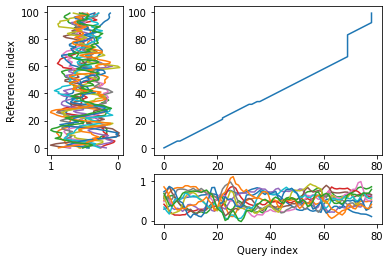

Stretch = 0.07
Distance  = 0.13


1      2       3
seg                speech  pause  speech
start in voice 1     3.45   3.67    3.71
start in voice 2     7.59   7.81    7.85
len in voice 1(s)    0.22   0.04    0.08
len in voice 2(s)    0.22   0.04    0.06
stretch              0.07   0.00    0.22

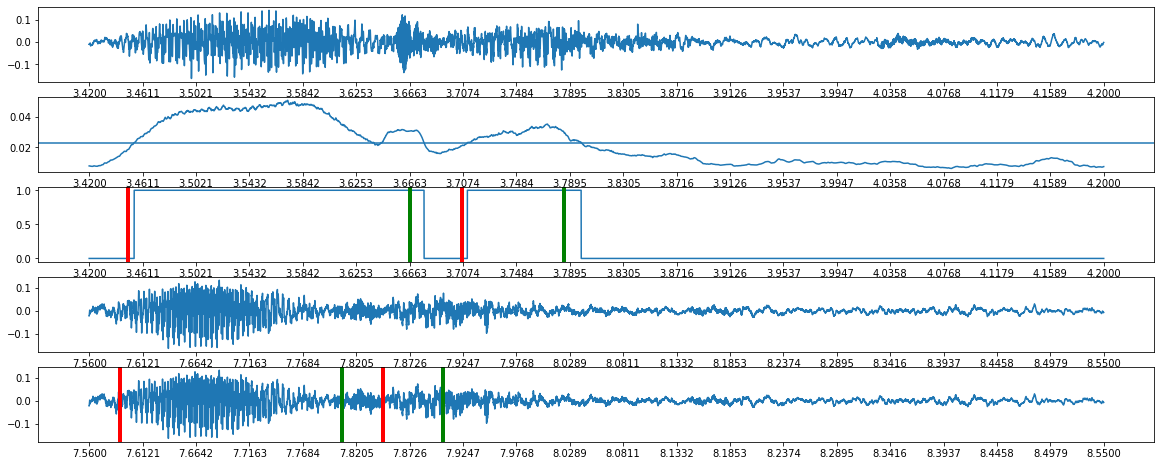

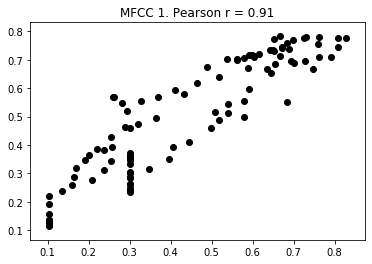

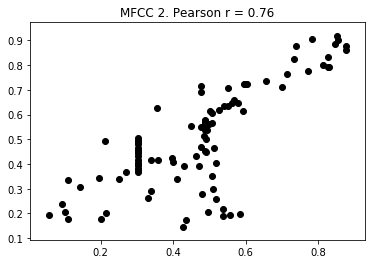

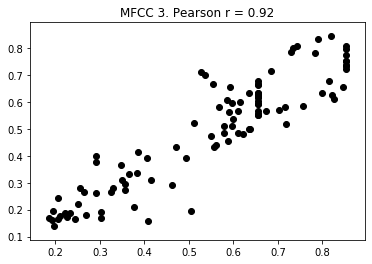

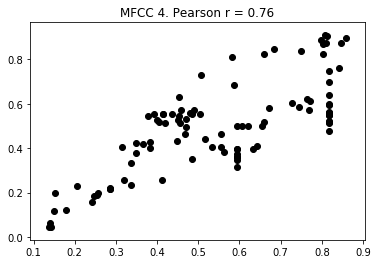

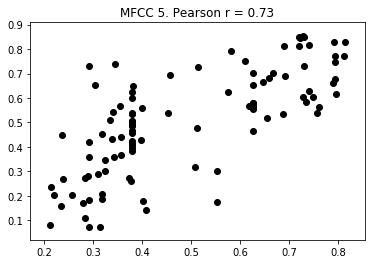

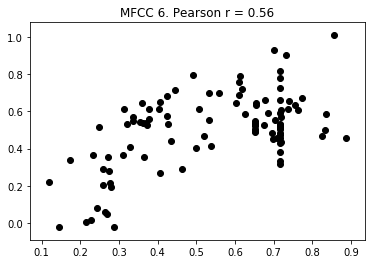

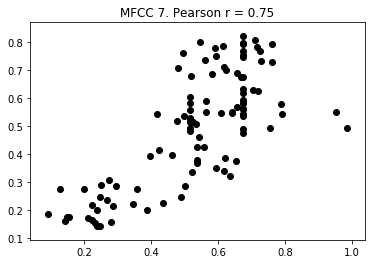

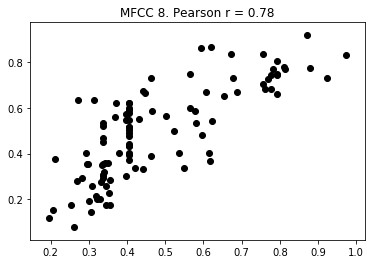

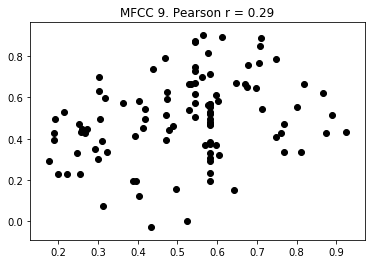

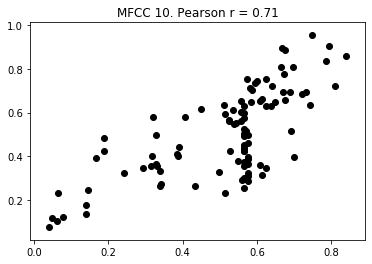

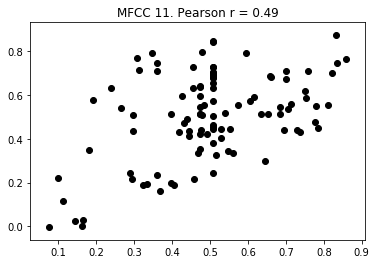

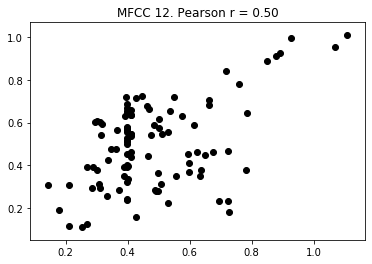

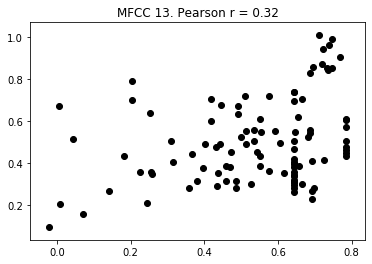

In [31]:
# should give dtw close to 0 and very small stretch

file1, seg1_1, seg1_2 = "report-normal1.wav", 3.42, 4.20 # "project"
file2, seg2_1, seg2_2 = "report-pause1.wav", 7.56, 8.55 # "project"

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, 
       threshold1=0.023, num_of_mfcc=13)

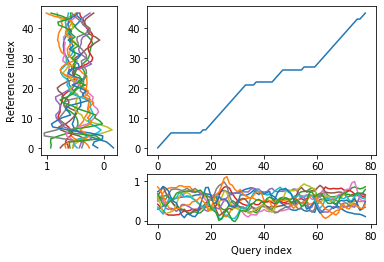

Stretch = 0.55
Distance  = 0.21


1      2       3
seg                speech  pause  speech
start in voice 1     3.45   3.67    3.71
start in voice 2     1.98   2.08    2.12
len in voice 1(s)    0.22   0.04    0.08
len in voice 2(s)    0.10   0.04    0.05
stretch              0.49   0.00    0.35

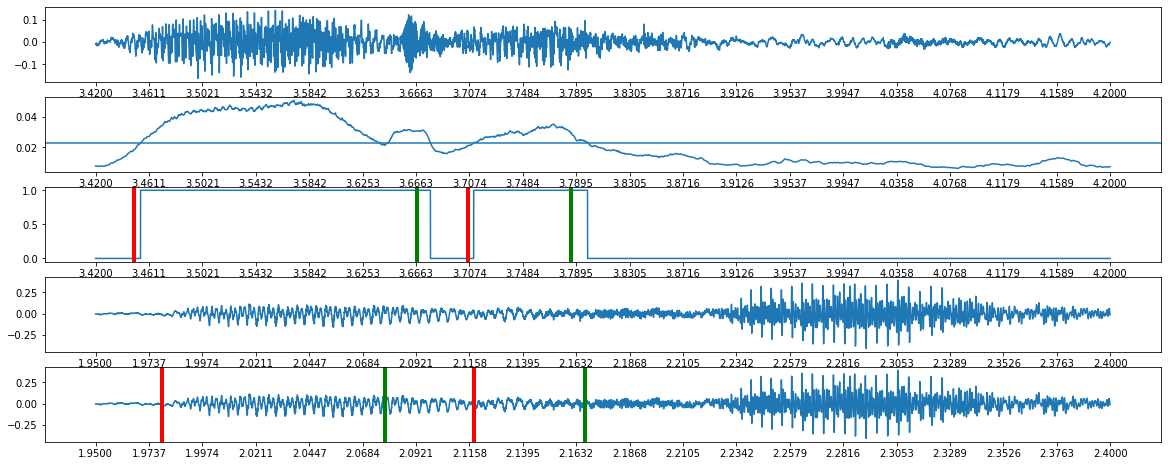

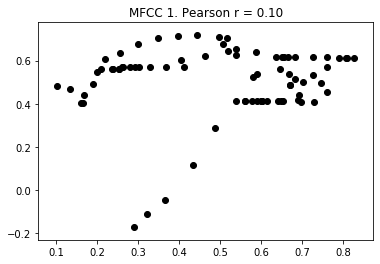

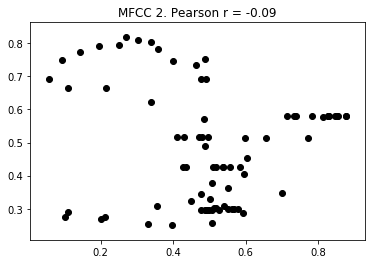

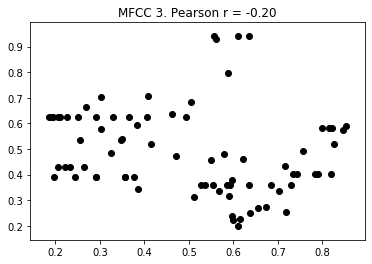

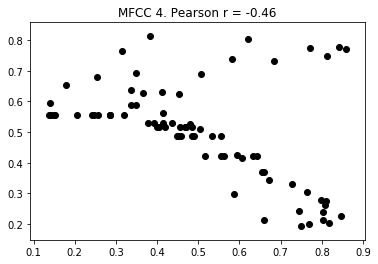

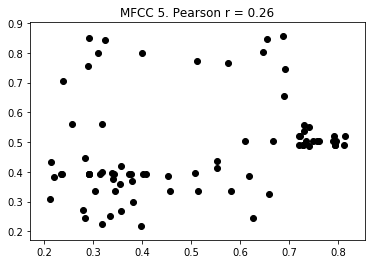

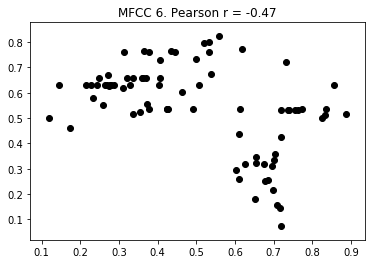

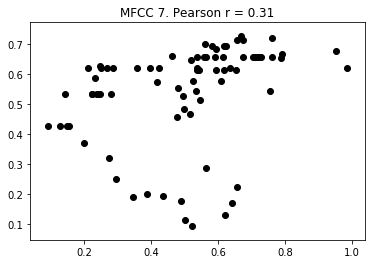

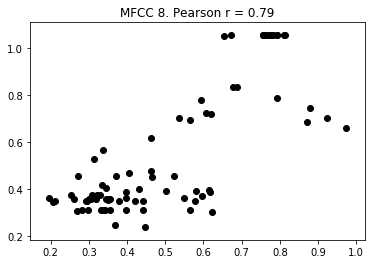

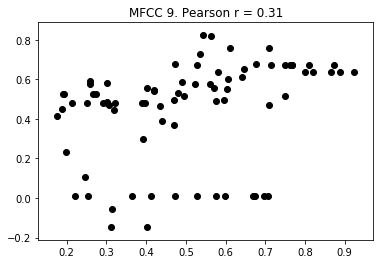

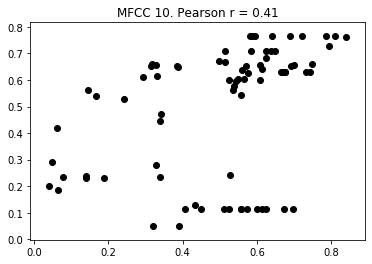

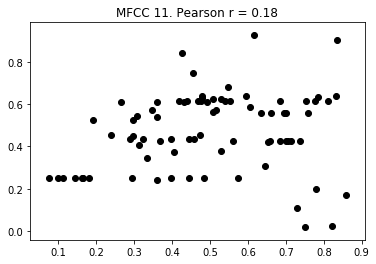

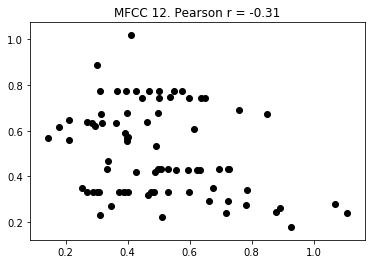

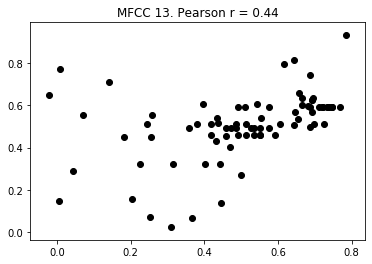

In [32]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 3.42, 4.20 # "project"
file2, seg2_1, seg2_2 = "report-pause1.wav", 1.95, 2.40 # "we have"

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, 
       threshold1=0.023, num_of_mfcc=13)

# We have really enjoyed the project - by word, normal1

### normal vs normal

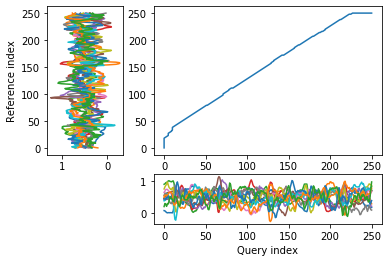

Stretch = 0.08
Distance  = 0.10


1      2       3      4       5      6       7      8   \
seg                speech  pause  speech  pause  speech  pause  speech  pause   
start in voice 1     1.62   1.73    1.78   1.96    2.14   2.74    2.80   3.08   
start in voice 2     1.90   2.01    2.06   2.24    2.41   3.01    3.09   3.37   
len in voice 1(s)    0.11   0.05    0.18   0.18    0.60   0.07    0.28   0.16   
len in voice 2(s)    0.11   0.05    0.18   0.17    0.61   0.08    0.28   0.15   
stretch              0.00   0.00    0.00   0.04    0.06   0.11    0.10   0.05   

                       9      10      11  
seg                speech  pause  speech  
start in voice 1     3.24   3.30    3.44  
start in voice 2     3.52   3.57    3.70  
len in voice 1(s)    0.06   0.14    0.35  
len in voice 2(s)    0.05   0.13    0.29  
stretch              0.15   0.16    0.11

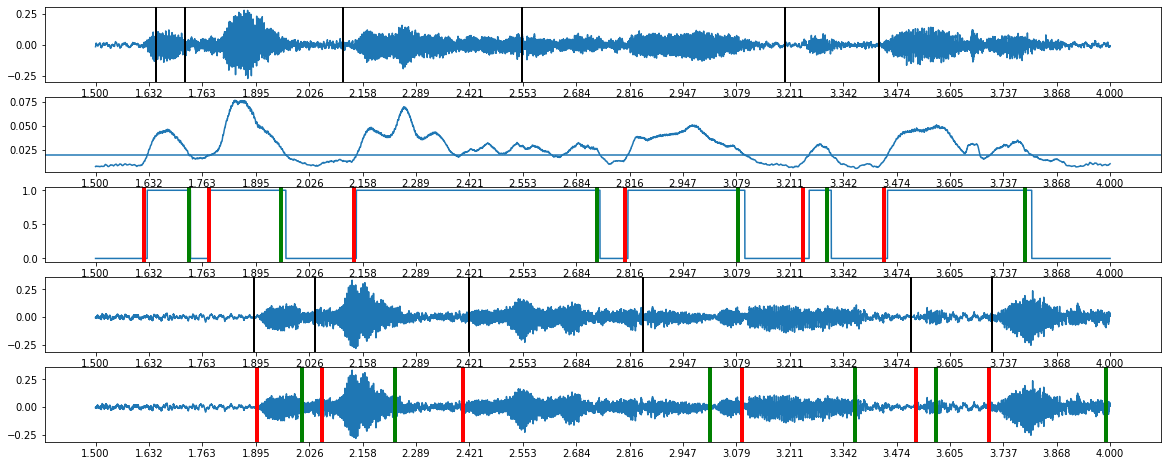

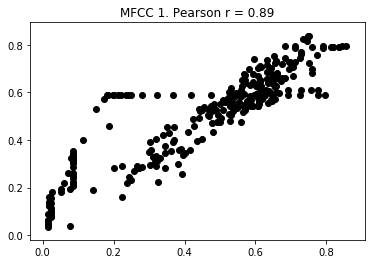

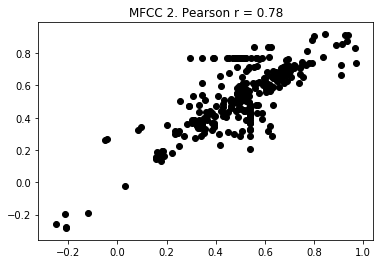

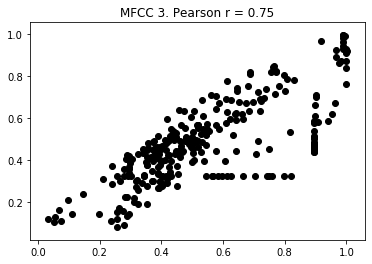

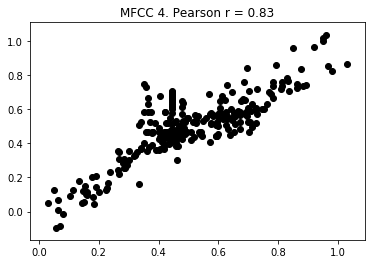

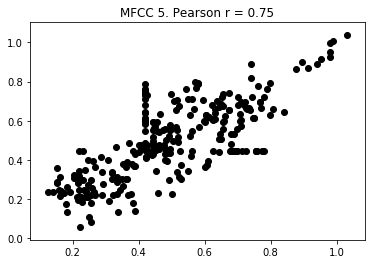

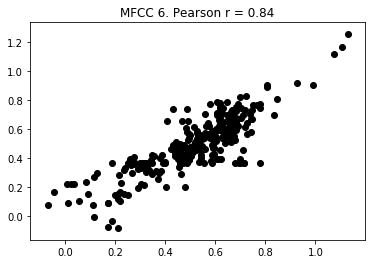

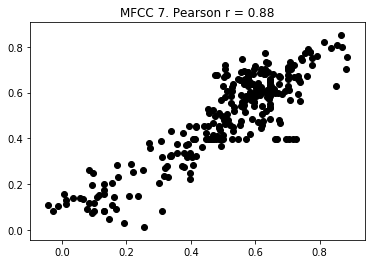

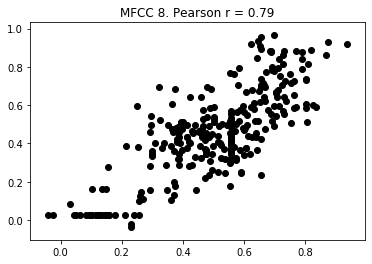

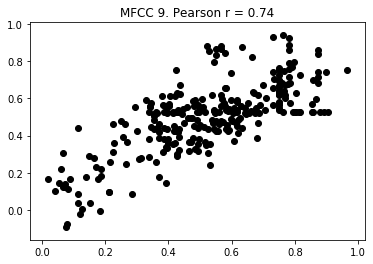

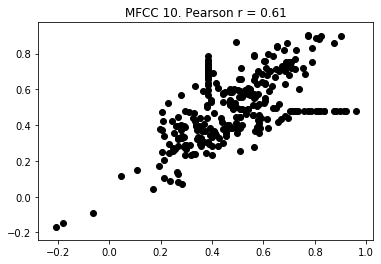

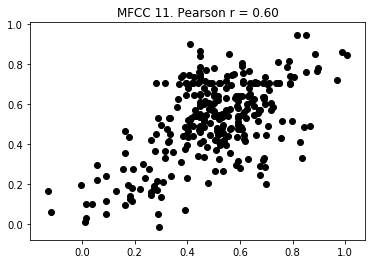

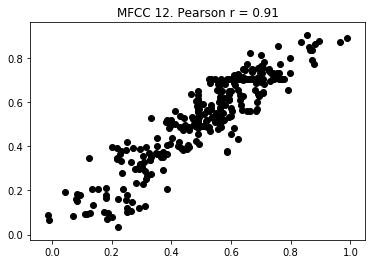

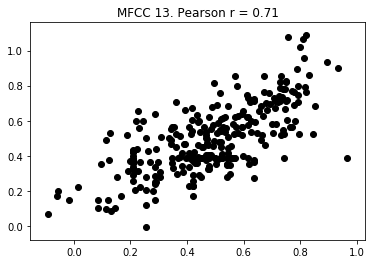

In [33]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-normal2.wav", 1.5, 4

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, 
       threshold1=0.02, 
      timelst1=timelst1, timelst2 = timelst2) # unit for input_min_pause and alpha = ms 

### normal vs pause

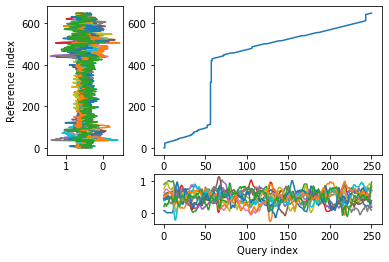

Stretch = 0.85
Distance  = 0.13


1      2       3      4       5      6       7      8   \
seg                speech  pause  speech  pause  speech  pause  speech  pause   
start in voice 1     1.62   1.73    1.78   1.96    2.14   2.74    2.80   3.08   
start in voice 2     2.35   2.50    2.56   2.91    6.34   7.00    7.07   7.32   
len in voice 1(s)    0.11   0.05    0.18   0.18    0.60   0.07    0.28   0.16   
len in voice 2(s)    0.15   0.06    0.35   3.44    0.66   0.07    0.25   0.13   
stretch              0.22   0.15    0.41   0.93    0.18   0.00    0.08   0.15   

                       9      10      11  
seg                speech  pause  speech  
start in voice 1     3.24   3.30    3.44  
start in voice 2     7.45   7.51    7.63  
len in voice 1(s)    0.06   0.14    0.35  
len in voice 2(s)    0.06   0.12    0.35  
stretch              0.00   0.11    0.00

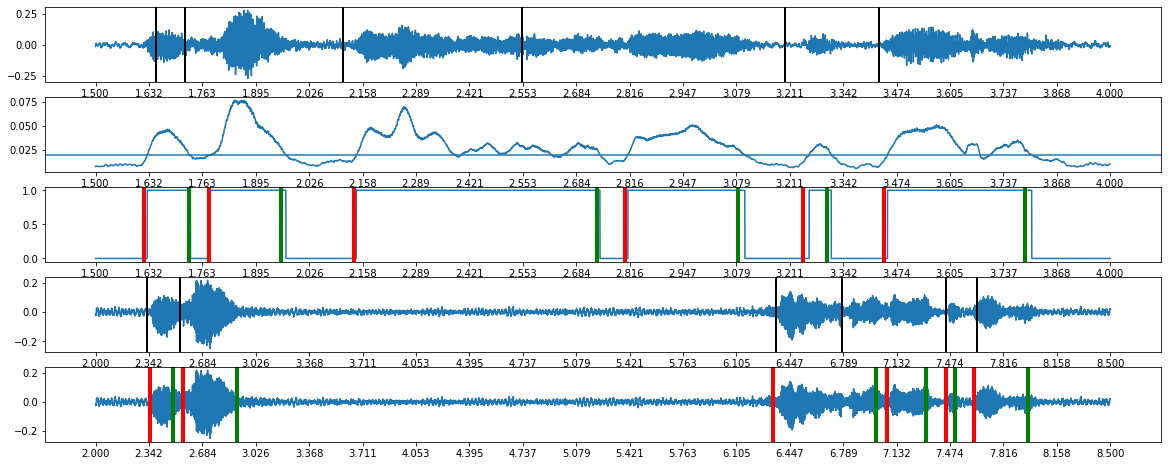

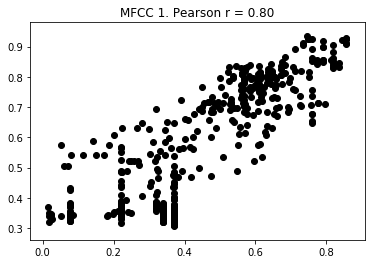

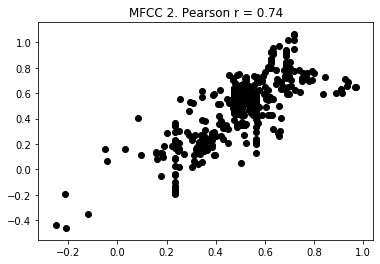

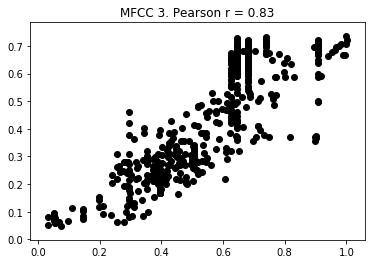

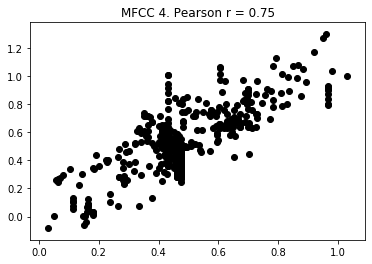

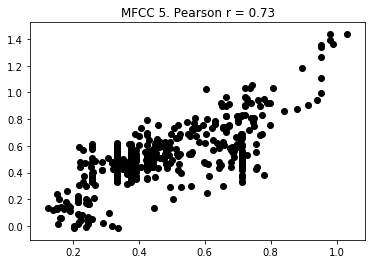

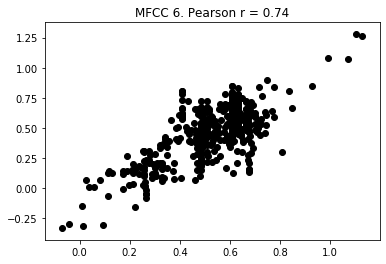

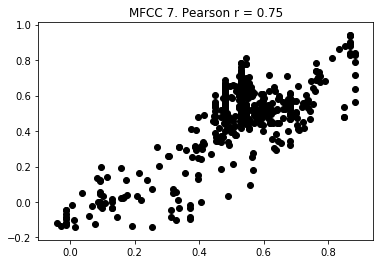

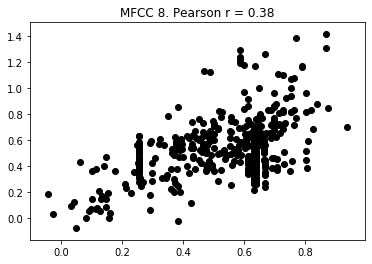

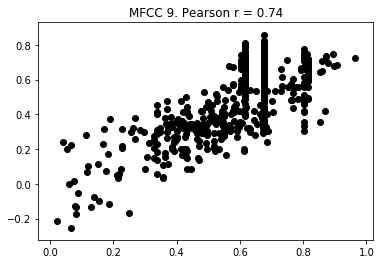

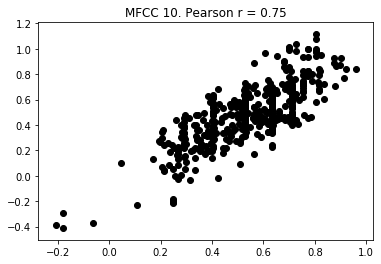

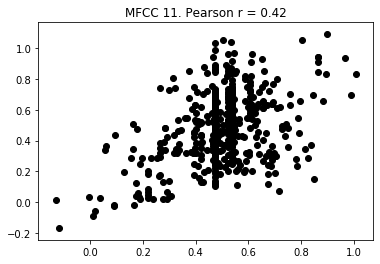

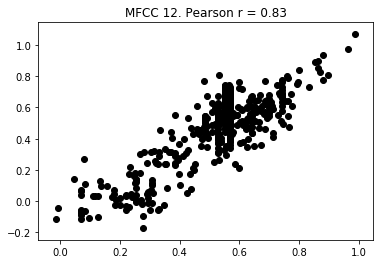

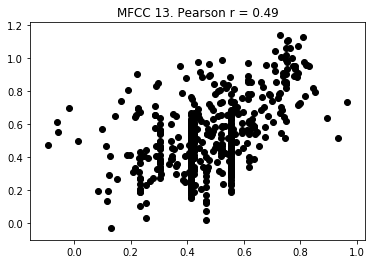

In [34]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 8.5

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, 
       threshold1 = 0.02, timelst1=timelst1, timelst2 = timelst2)

### normal vs long word

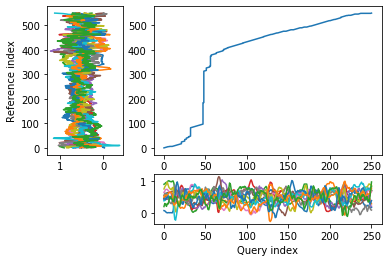

Stretch = 0.87
Distance  = 0.13


1      2       3      4       5      6       7      8   \
seg                speech  pause  speech  pause  speech  pause  speech  pause   
start in voice 1     1.62   1.73    1.78   1.96    2.14   2.74    2.80   3.08   
start in voice 2     1.58   1.76    1.91   2.46    5.37   6.06    6.12   6.33   
len in voice 1(s)    0.11   0.05    0.18   0.18    0.60   0.07    0.28   0.16   
len in voice 2(s)    0.18   0.15    0.55   2.92    0.69   0.06    0.21   0.11   
stretch              0.33   0.64    0.61   0.92    0.10   0.12    0.20   0.26   

                       9      10      11  
seg                speech  pause  speech  
start in voice 1     3.24   3.30    3.44  
start in voice 2     6.44   6.49    6.63  
len in voice 1(s)    0.06   0.14    0.35  
len in voice 2(s)    0.05   0.14    0.31  
stretch              0.15   0.00    0.17

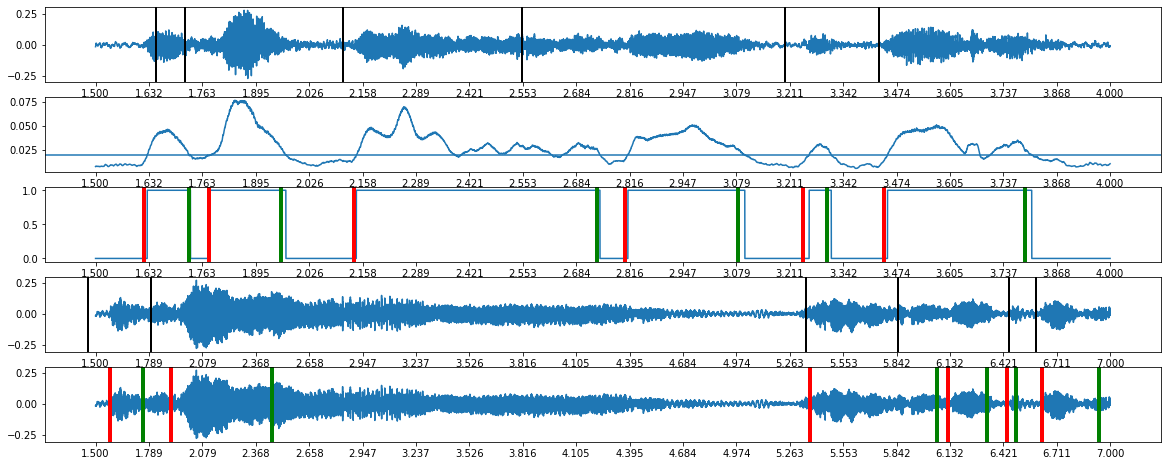

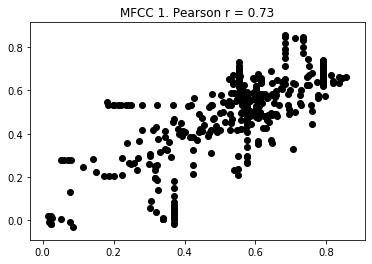

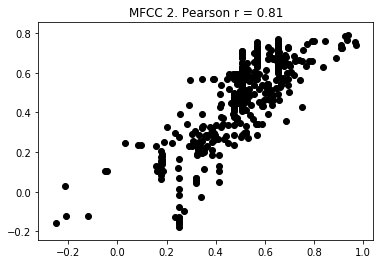

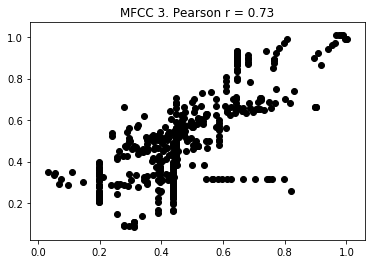

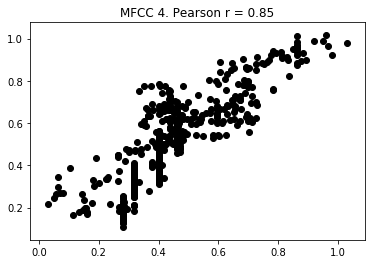

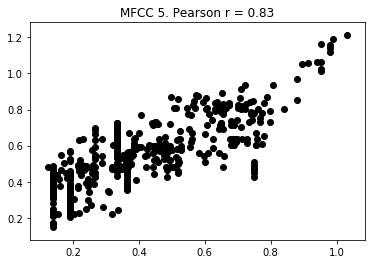

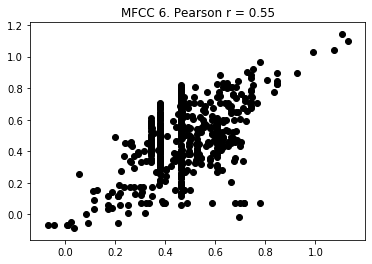

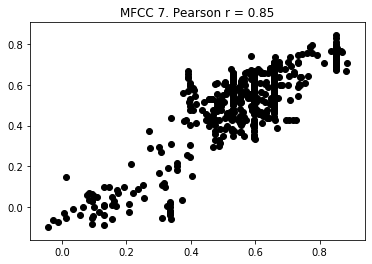

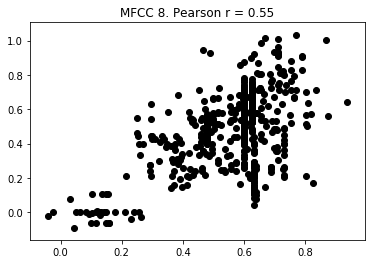

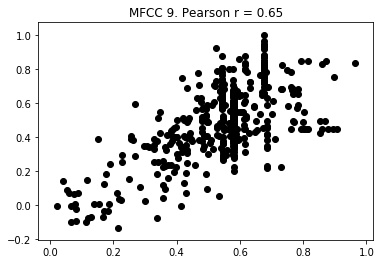

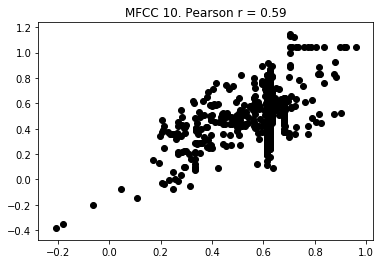

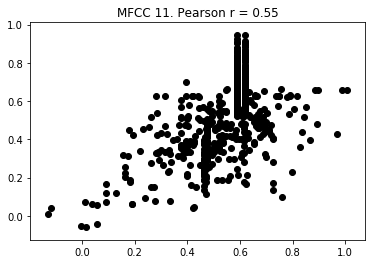

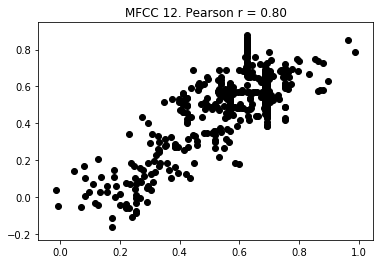

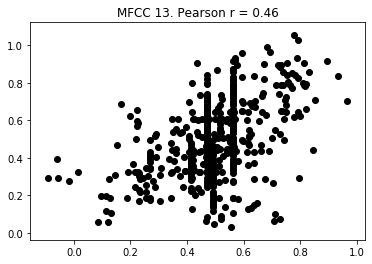

In [35]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-longword1.wav", 1.5, 7

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.46, 1.80, 5.35, 5.85, 6.45, 6.6]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, 
       threshold1 = 0.02, timelst1=timelst1, timelst2 = timelst2)

### normal vs combo

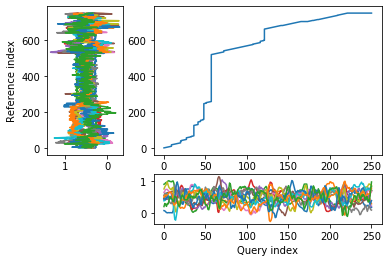

Stretch = 0.82
Distance  = 0.14


1      2       3      4       5      6       7      8   \
seg                speech  pause  speech  pause  speech  pause  speech  pause   
start in voice 1     1.62   1.73    1.78   1.96    2.14   2.74    2.80   3.08   
start in voice 2     1.70   1.93    2.07   3.04    6.74   8.11    8.18   8.44   
len in voice 1(s)    0.11   0.05    0.18   0.18    0.60   0.07    0.28   0.16   
len in voice 2(s)    0.23   0.14    0.98   3.70    1.37   0.07    0.26   0.08   
stretch              0.46   0.61    0.77   0.94    0.48   0.00    0.05   0.45   

                       9      10      11  
seg                speech  pause  speech  
start in voice 1     3.24   3.30    3.44  
start in voice 2     8.52   8.57    8.70  
len in voice 1(s)    0.06   0.14    0.35  
len in voice 2(s)    0.05   0.13    0.27  
stretch              0.15   0.06    0.20

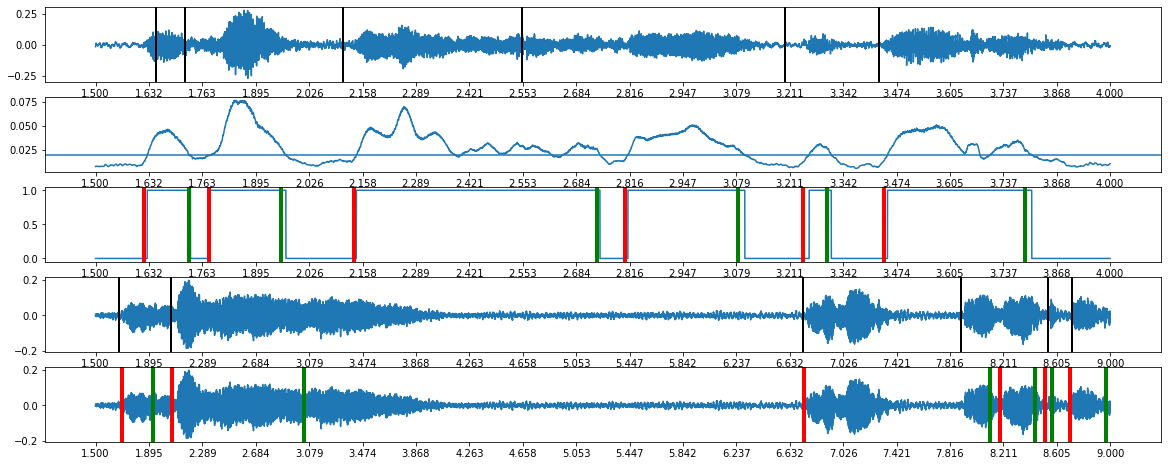

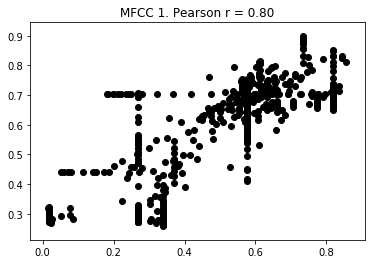

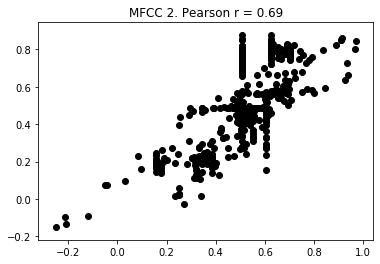

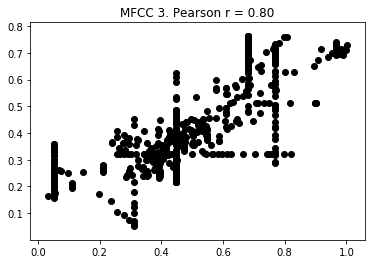

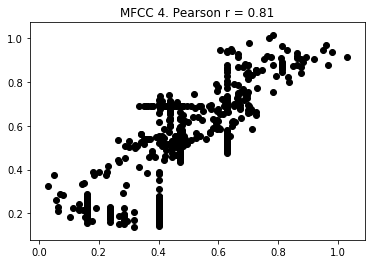

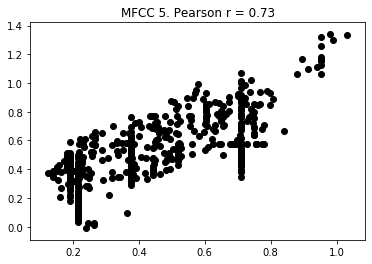

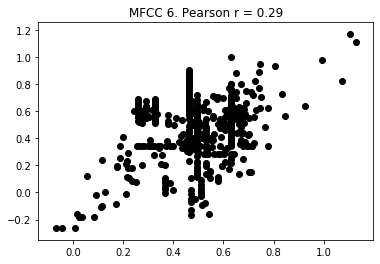

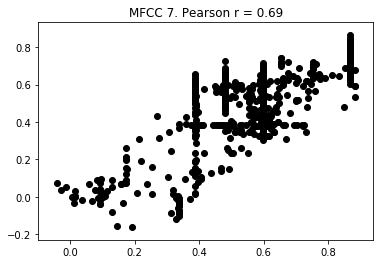

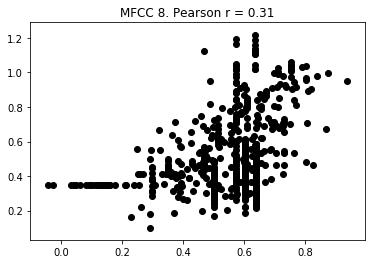

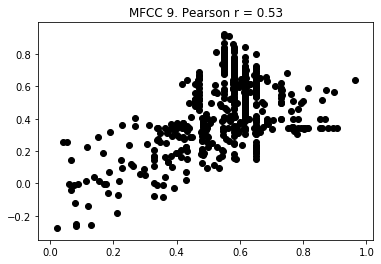

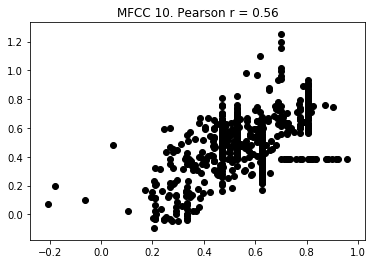

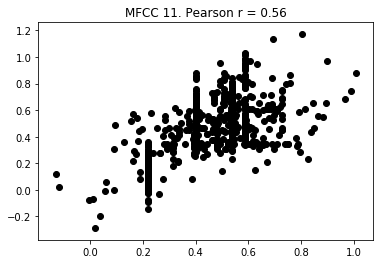

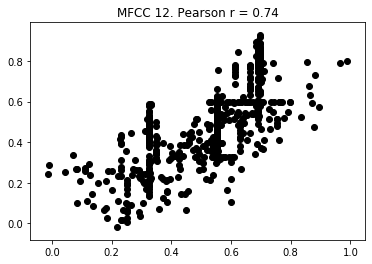

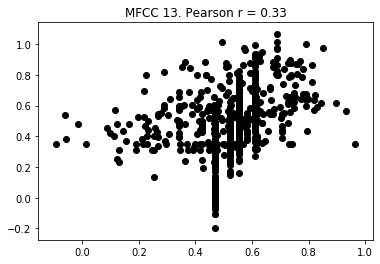

In [36]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, 
       threshold1 = 0.02, timelst1=timelst1, timelst2 = timelst2)

### normal vs random

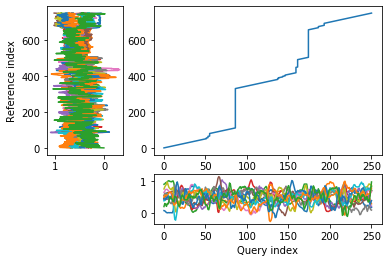

Stretch = 0.79
Distance  = 0.19


1      2       3      4       5      6       7      8   \
seg                speech  pause  speech  pause  speech  pause  speech  pause   
start in voice 1     1.62   1.73    1.78   1.96    2.14   2.74    2.80   3.08   
start in voice 2     1.62   1.73    1.78   1.96    2.39   5.17    5.24   5.66   
len in voice 1(s)    0.11   0.05    0.18   0.18    0.60   0.07    0.28   0.16   
len in voice 2(s)    0.11   0.05    0.18   0.43    2.78   0.07    0.43   2.39   
stretch              0.00   0.00    0.00   0.51    0.72   0.00    0.28   0.91   

                       9      10      11  
seg                speech  pause  speech  
start in voice 1     3.24   3.30    3.44  
start in voice 2     8.05   8.11    8.42  
len in voice 1(s)    0.06   0.14    0.35  
len in voice 2(s)    0.06   0.31    0.35  
stretch              0.00   0.48    0.00

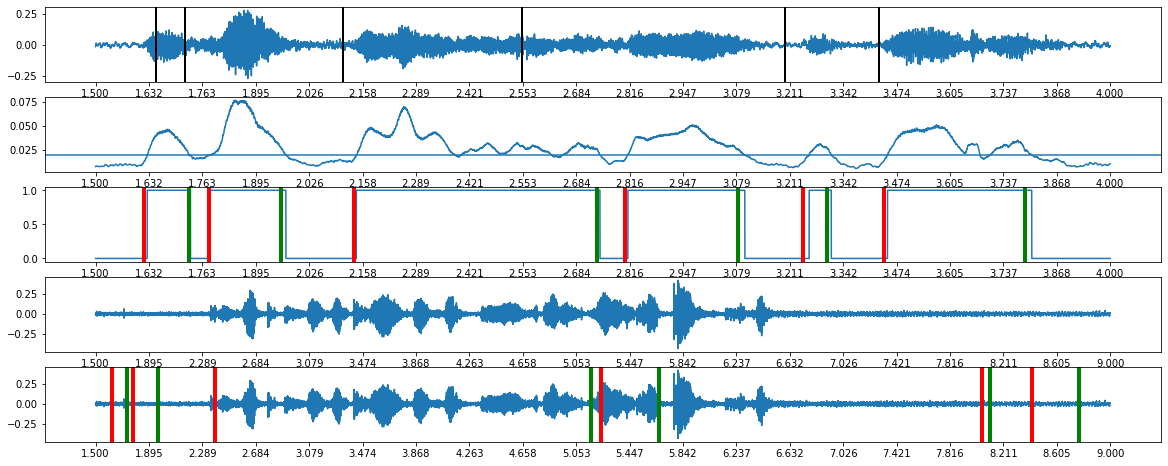

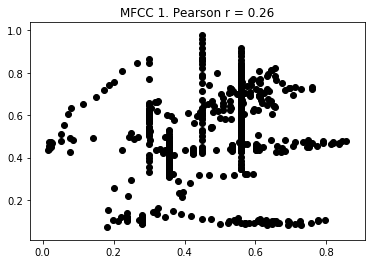

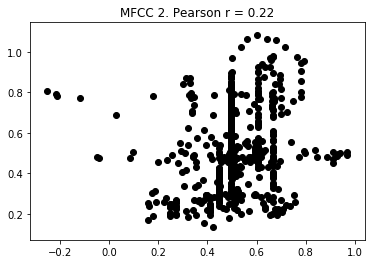

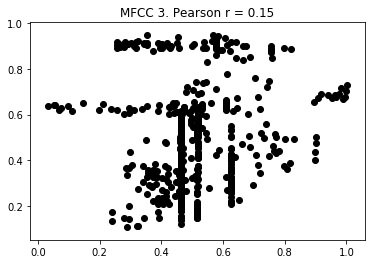

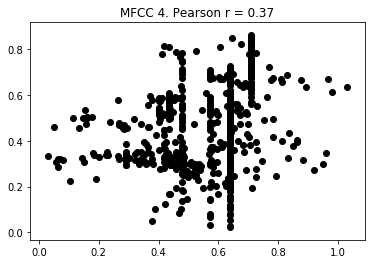

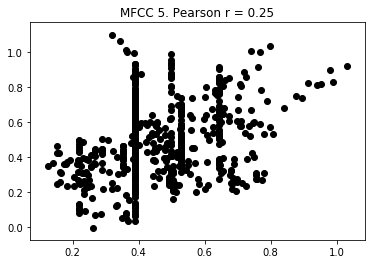

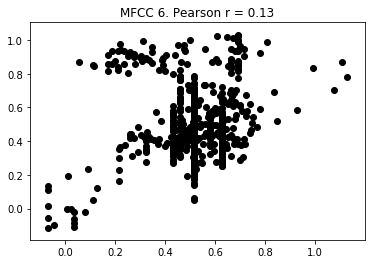

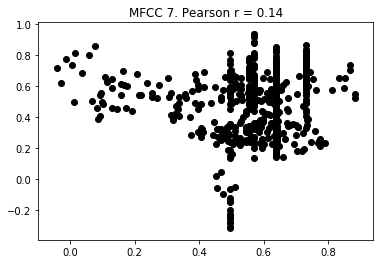

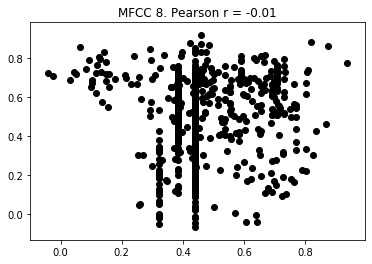

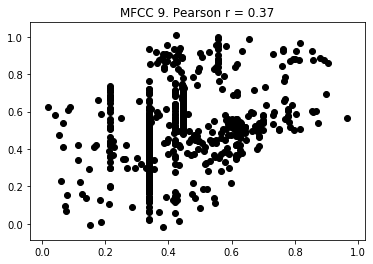

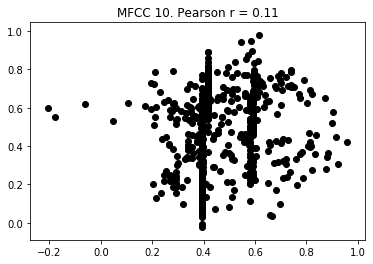

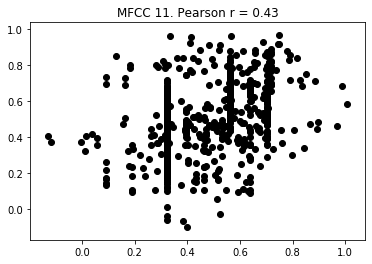

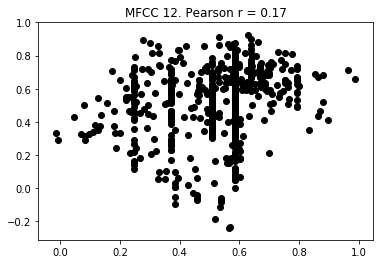

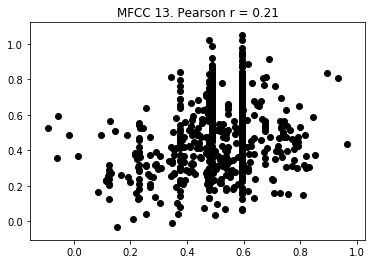

In [38]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "torgo-healthy.wav", 1.5, 9

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, 
       threshold1 = 0.02, timelst1=timelst1)

### inserted pause

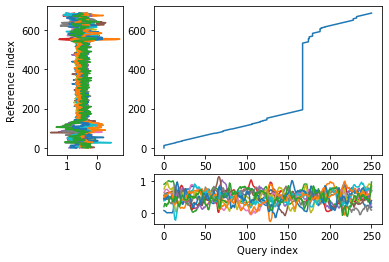

Stretch = 0.87
Distance  = 0.15


1      2       3      4       5      6       7      8   \
seg                speech  pause  speech  pause  speech  pause  speech  pause   
start in voice 1     1.62   1.73    1.77   1.97    2.14   2.74    2.79   3.09   
start in voice 2     2.71   2.84    2.88   3.08    3.23   3.89    4.03   4.33   
len in voice 1(s)    0.11   0.04    0.20   0.17    0.60   0.06    0.30   0.15   
len in voice 2(s)    0.13   0.04    0.20   0.15    0.67   0.14    0.30   3.68   
stretch              0.12   0.00    0.00   0.09    0.10   0.53    0.00   0.95   

                       9      10      11  
seg                speech  pause  speech  
start in voice 1     3.24   3.30    3.43  
start in voice 2     8.01   8.30    8.60  
len in voice 1(s)    0.06   0.13    0.37  
len in voice 2(s)    0.29   0.30    0.45  
stretch              0.76   0.50    0.14

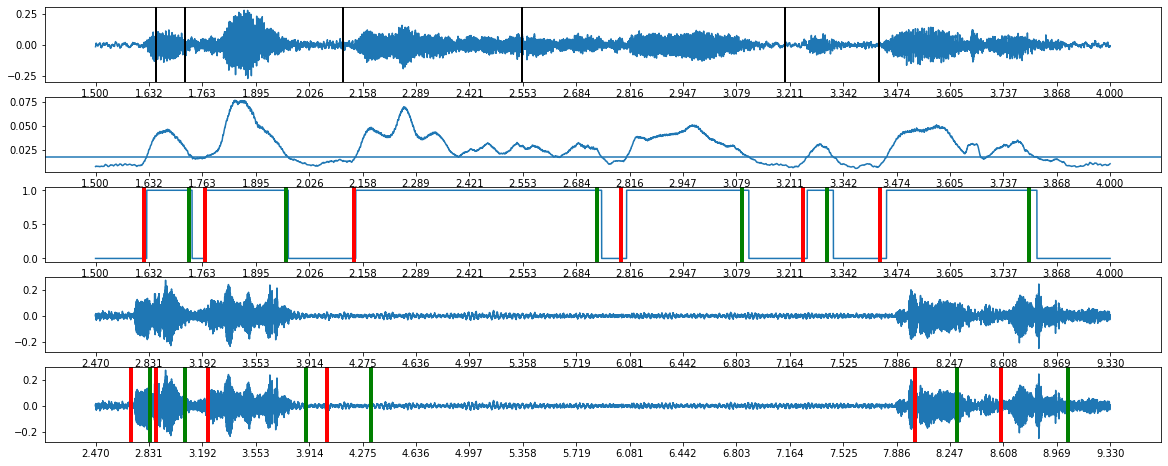

In [27]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-normal2-pause.wav", 2.47, 9.33

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = []

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.018,
      timelst1=timelst1, timelst2 = timelst2)

# We have really enjoyed the project - by word, normal2

### normal vs pause

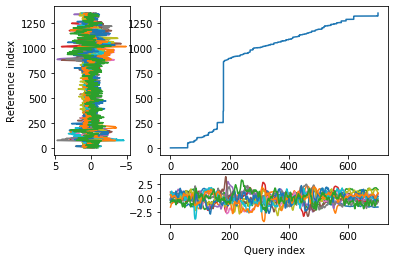

Overall normalized stretch =  0.9663331304006694
                       1         2         3         4         5         6   \
seg                speech     pause    speech     pause    speech     pause   
start in voice 1  1.90883   2.25783   2.40741    2.9708   3.03561   3.39459   
start in voice 2    2.349   2.92735   6.31766    7.0057    7.0406   7.34972   
stretch           0.88194  0.995686  0.825393  0.879134  0.859488  0.896376   

                        7         8         9         10        11  
seg                 speech     pause    speech     pause    speech  
start in voice 1   3.54915   3.59402   3.72365   4.11752   4.19729  
start in voice 2   7.46439   7.54416   7.65883   8.09758   8.12251  
stretch           0.803069  0.908906  0.875232  0.891973  0.977102  

DTW distance =  2.4434178655310426


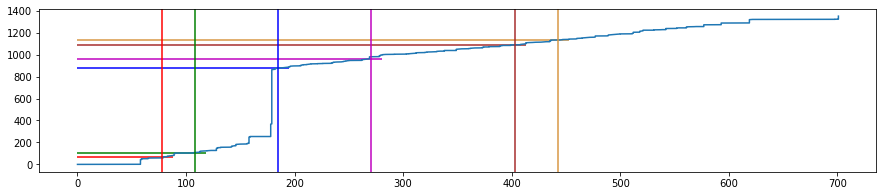

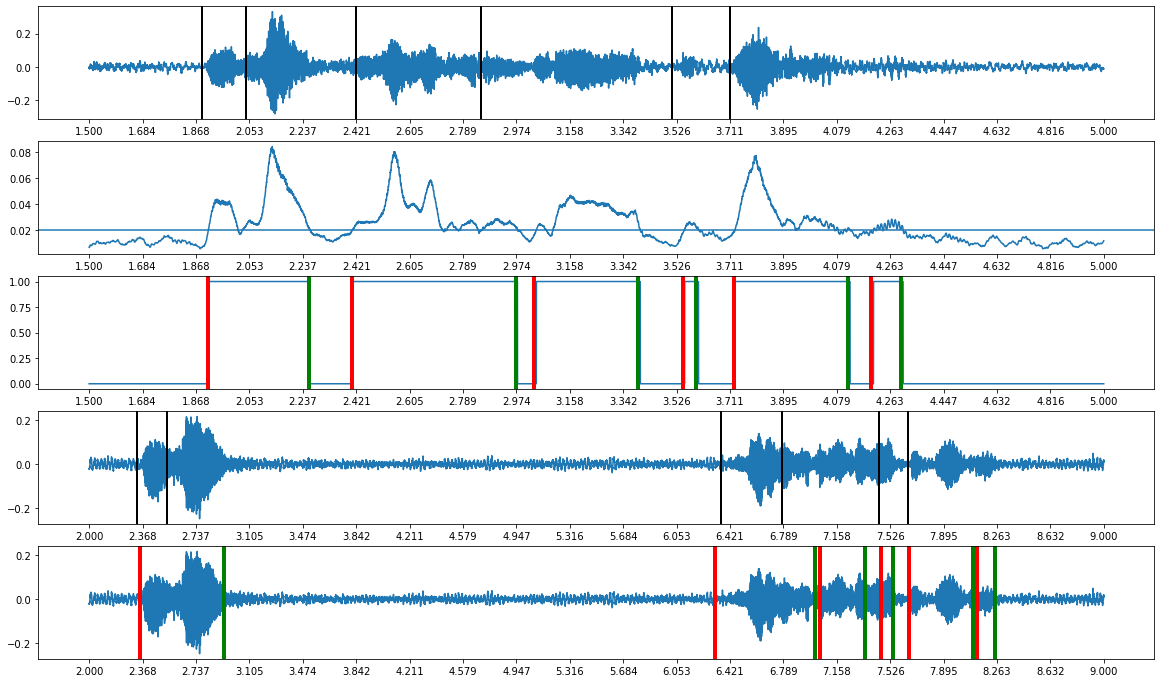

In [103]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 9

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]
timelst2 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2)

### normal vs long word

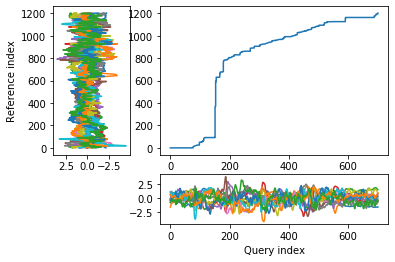

Overall normalized stretch =  0.9512025776550707
                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   1.90883   2.25783   2.40741    2.9708   3.03561   3.39459   
start in voice 2   1.58476   3.33476   5.38889   6.01709   6.10185   6.32621   
stretch           0.974219  0.985359  0.895908  0.882709  0.749242  0.923452   

                        7         8         9         10        11  
seg                 speech     pause    speech     pause    speech  
start in voice 1   3.54915   3.59402   3.72365   4.11752   4.19729  
start in voice 2    6.4708   6.49573   6.66524    7.0641   7.10897  
stretch           0.803276  0.882709  0.877691  0.856343  0.947825  

DTW distance =  2.645631188944761


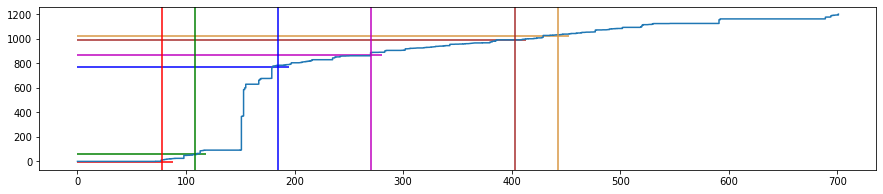

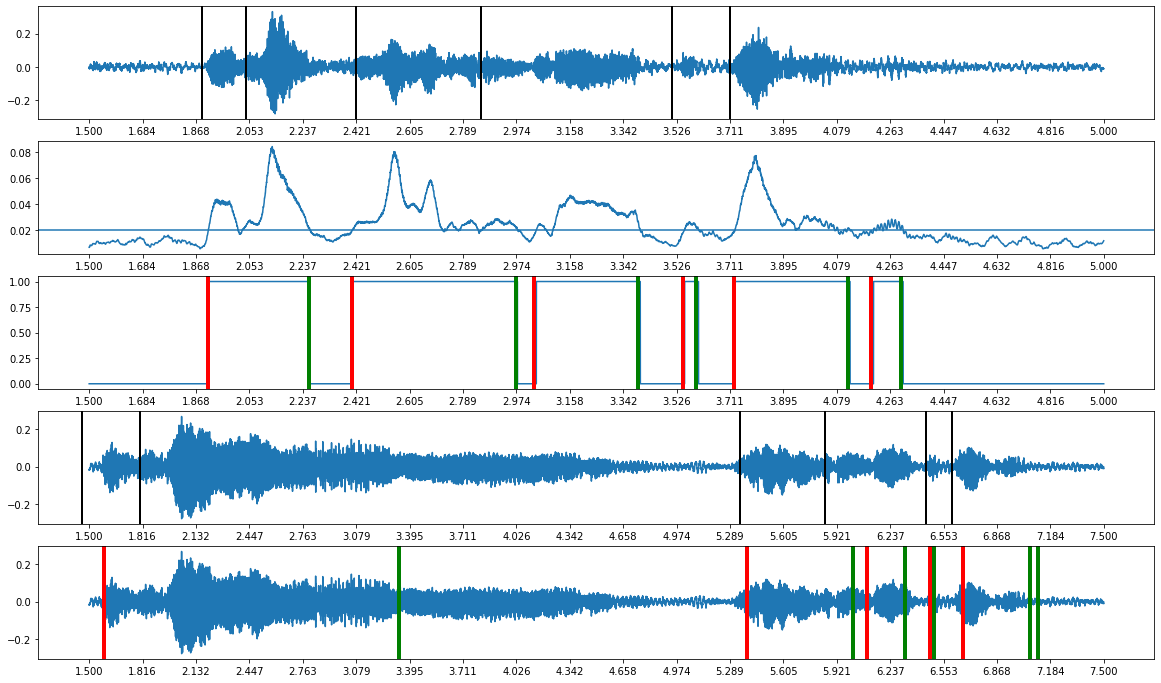

In [104]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-longword1.wav", 1.5, 7.5

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]
timelst2 = [1.46, 1.80, 5.35, 5.85, 6.45, 6.6]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2)

### normal vs combo

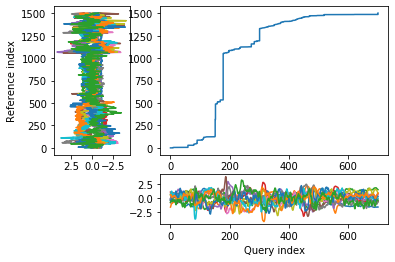

Overall normalized stretch =  0.9693590233595608
                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   1.90883   2.25783   2.40741    2.9708   3.03561   3.39459   
start in voice 2   1.71439   3.08048   6.76994   7.44801   8.15598   8.49501   
stretch           0.956055  0.992315  0.917122  0.987102  0.748816  0.819154   

                        7         8         9         10       11  
seg                 speech     pause    speech     pause   speech  
start in voice 1   3.54915   3.59402   3.72365   4.11752  4.19729  
start in voice 2   8.55484   8.59473    8.7443   8.90883  8.91382  
stretch           0.858388  0.749851  0.916652  0.936478        1  

DTW distance =  2.949194602915999


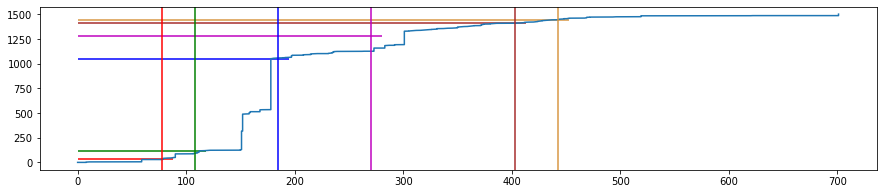

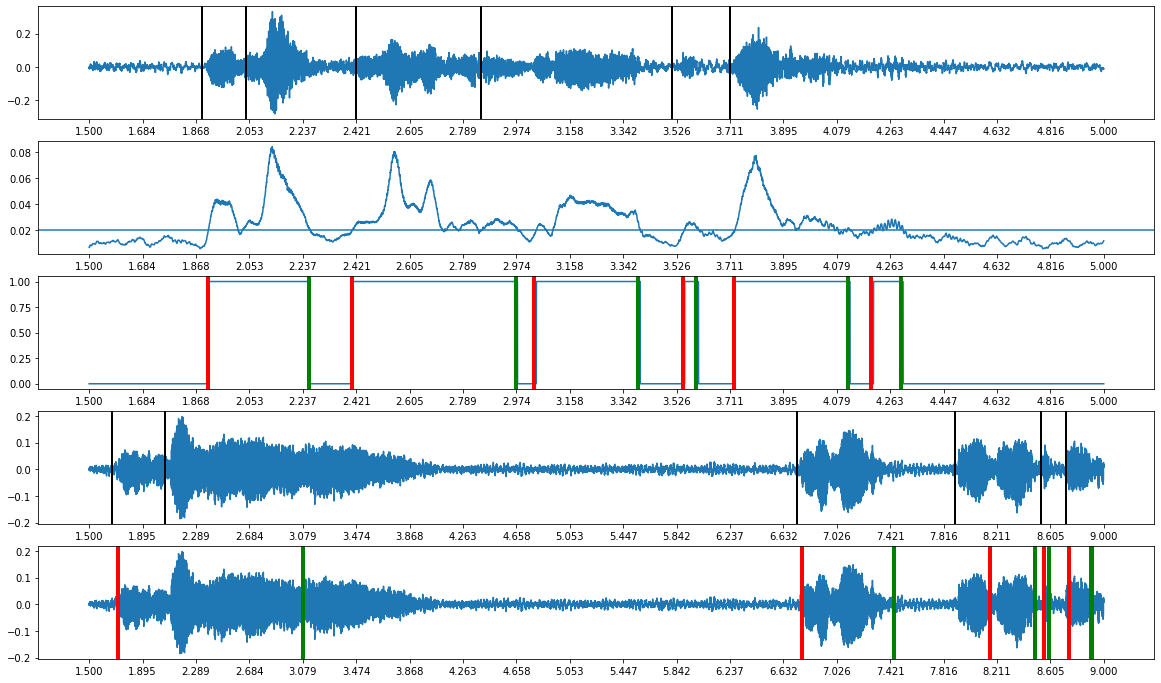

In [24]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]
timelst2 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2)

# bamboo walls are getting to be very popular

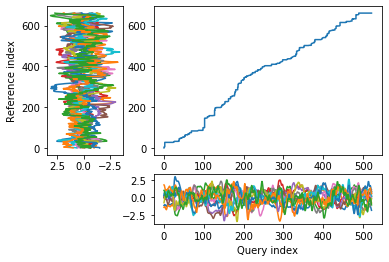

Overall normalized stretch =  0.8710804521234169
                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   3.52452   3.69387   3.74368   3.87318   3.90805   4.14215   
start in voice 2   1.84444   2.01877   2.07356   2.12835   2.19808   2.76092   
stretch           0.865297  0.869385  0.892271  0.936663  0.919178  0.831307   

                        7        8         9         10       11        12  \
seg                 speech    pause    speech     pause   speech     pause   
start in voice 1    4.2567  4.33142   4.43103   4.76973  4.88429   4.92414   
start in voice 2   2.97011  3.25402   3.43831   3.74215  3.82184   3.85172   
stretch           0.945944  0.75477  0.845281  0.695575        1  0.772887   

                        13        14        15        16       17        18  \
seg                 speech     pause    speech     pause   speech     pause   
s

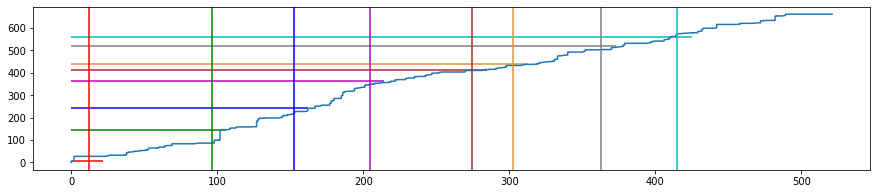

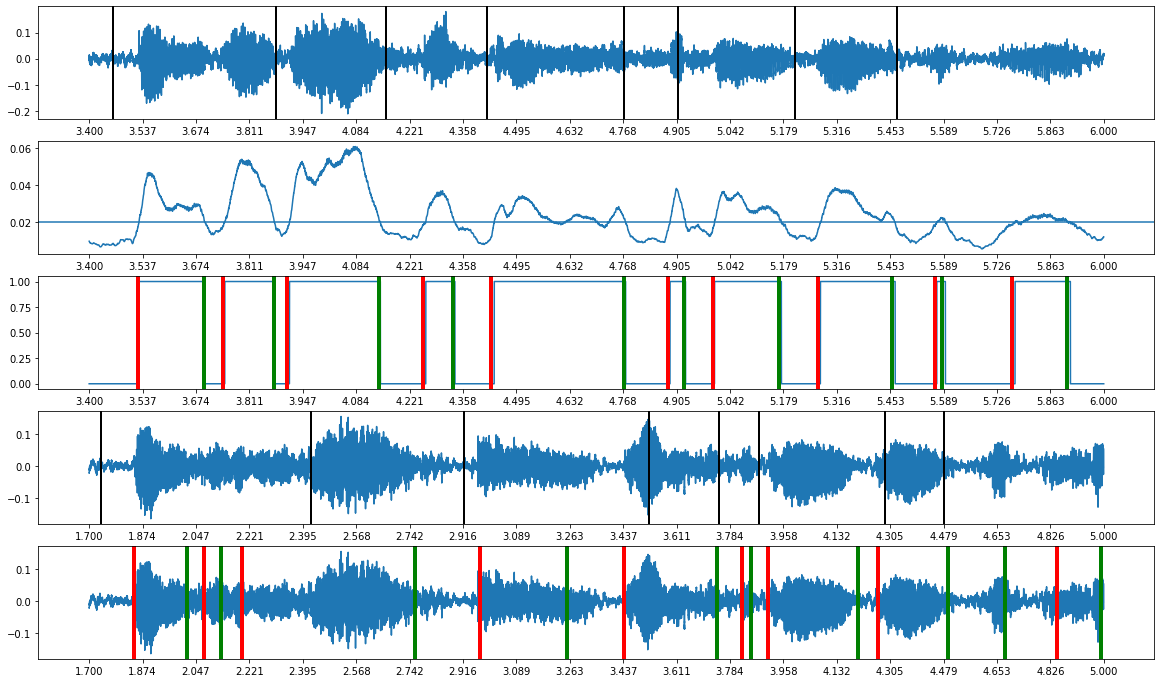

In [108]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "02.wav", 1.7, 5

timelst1 = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
timelst2 = [1.74, 2.42, 2.92, 3.52, 3.75, 3.88, 4.29, 4.48] 

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, timelst1 = timelst1, timelst2 = timelst2, input_min_pause = 30, threshold1=0.02)
# unit = ms 

# bamboo walls are getting to be very popular

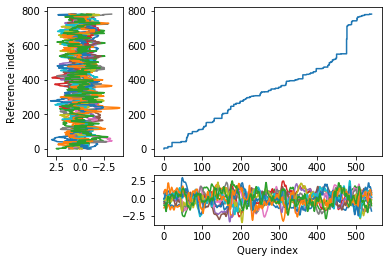

Overall normalized stretch =  0.9181980743604455
                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   3.51919   4.15185   4.24151   4.37601   4.43081   4.77454   
start in voice 2    2.8893   3.84077   4.01513   4.16458   4.20941   4.44852   
stretch           0.904829  0.954709  0.889476  0.933903  0.895497  0.931949   

                        7         8         9         10        11        12  \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   4.87417   5.18303   5.26273   5.46697   5.55166   5.60148   
start in voice 2   4.53321   4.85701   4.92675   5.19576   5.43487   5.43985   
stretch           0.872528  0.873248  0.869413  0.905764  0.877736  0.976226   

                        13  
seg                 speech  
start in voice 1   5.73598  
start in voice 2    6.2917  
stretch           0.888284  

DTW

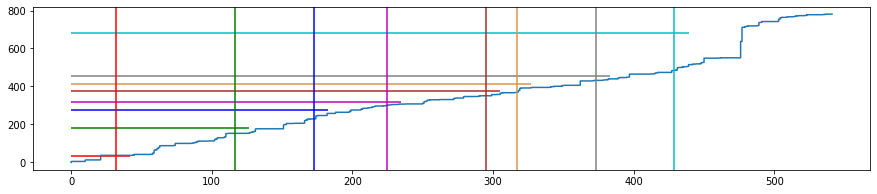

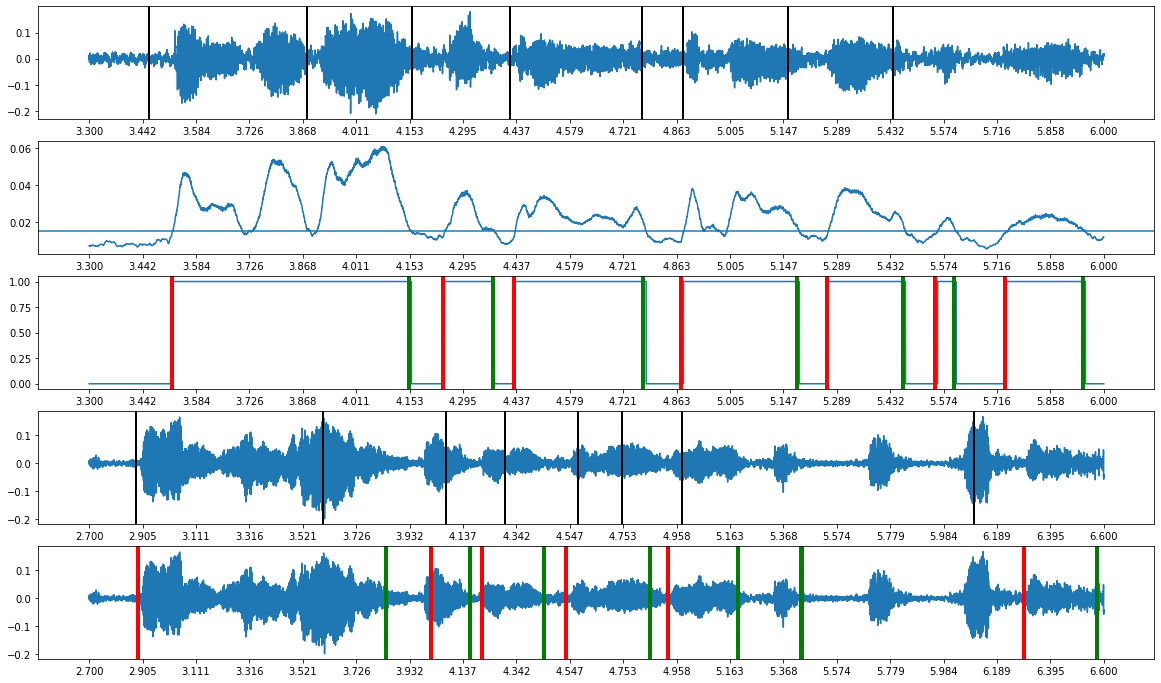

In [16]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 6
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 2.7, 6.6

timelst1 = [3.46, 3.88, 4.16, 4.42, 4.77, 4.88, 5.16, 5.44]
timelst2 = [2.88, 3.6, 4.07, 4.3, 4.58, 4.75, 4.98, 6.10]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, timelst1 = timelst1, timelst2 = timelst2, input_min_pause = 30, threshold1=0.015)

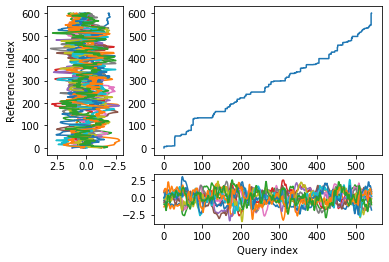

Overall normalized stretch =  0.9192353298631945
                        1         2         3        4         5        6   \
seg                 speech     pause    speech    pause    speech    pause   
start in voice 1   3.51919   4.15185   4.24151  4.37601   4.43081  4.77454   
start in voice 2   2.27399   2.91661   3.02122  3.19059   3.23044   3.4845   
stretch           0.930339  0.847001  0.883863  0.91924  0.907229        1   

                        7        8         9         10        11        12  \
seg                 speech    pause    speech     pause    speech     pause   
start in voice 1   4.87417  5.18303   5.26273   5.46697   5.55166   5.60148   
start in voice 2   3.48948  3.84815   3.85314   4.08229   4.15701   4.28155   
stretch           0.895737    0.914  0.920212  0.864005  0.960328  0.849605   

                        13  
seg                 speech  
start in voice 1   5.73598  
start in voice 2   4.38616  
stretch           0.807204  

DTW distance =  2.

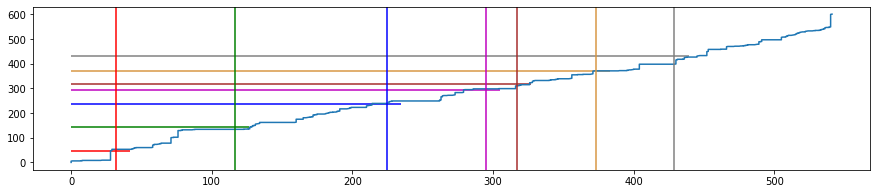

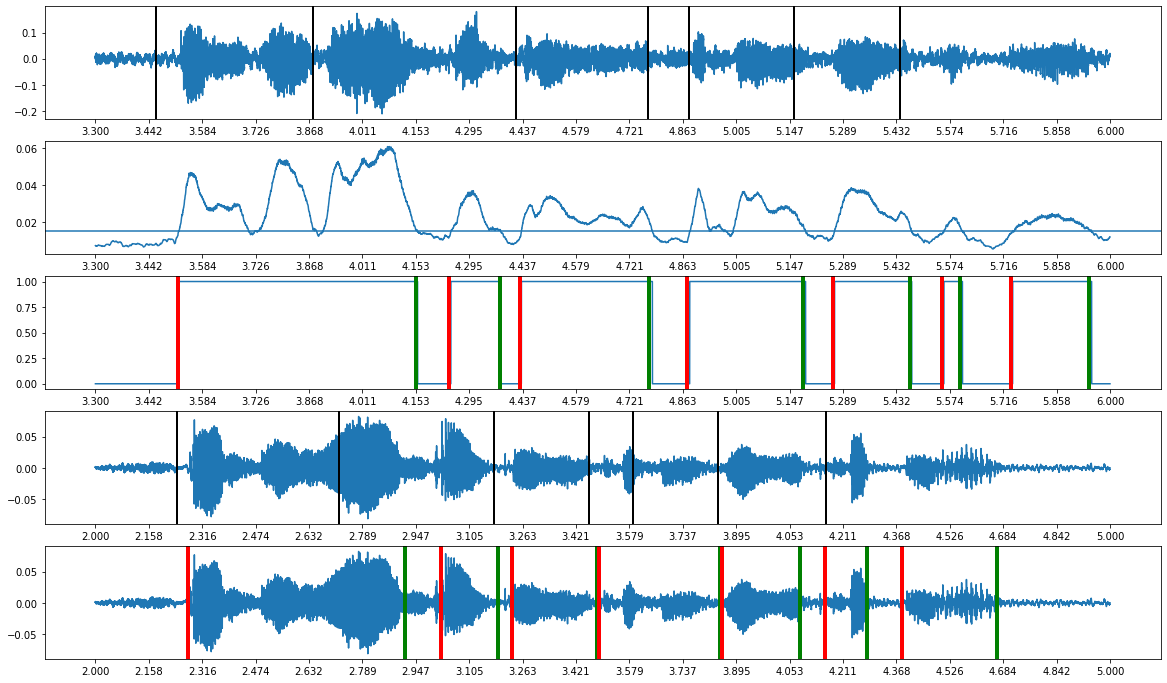

In [17]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 6
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5

timelst1 = [3.46, 3.88, 4.42, 4.77, 4.88, 5.16, 5.44] ;
timelst2 = [2.24, 2.72, 3.18, 3.46, 3.59, 3.84, 4.16]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, timelst1 = timelst1, timelst2 = timelst2, input_min_pause = 30, threshold1=0.015)

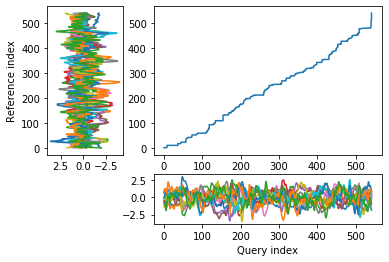

Overall normalized stretch =  0.8459936634456736
                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   3.51919   4.15185   4.24151   4.37601   4.43081   4.77454   
start in voice 2   2.08967   2.69742   2.81199   2.98635   3.02122    3.2703   
stretch           0.886562  0.767433  0.743533  0.913842  0.833448  0.956371   

                        7         8         9         10        11       12  \
seg                 speech     pause    speech     pause    speech    pause   
start in voice 1   4.87417   5.18303   5.26273   5.46697   5.55166  5.60148   
start in voice 2   3.34004   3.58911   3.65387   3.87306   4.00258  4.07731   
stretch           0.777349  0.831926  0.893247  0.738796  0.809256   0.8813   

                        13  
seg                 speech  
start in voice 1   5.73598  
start in voice 2   4.20185  
stretch           0.869571  

DTW dist

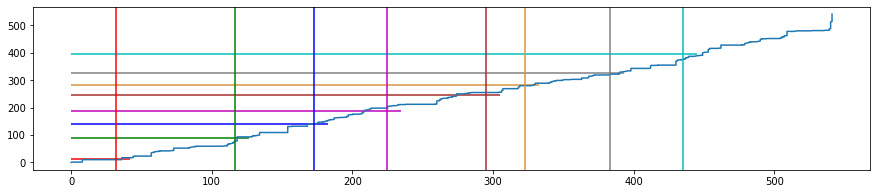

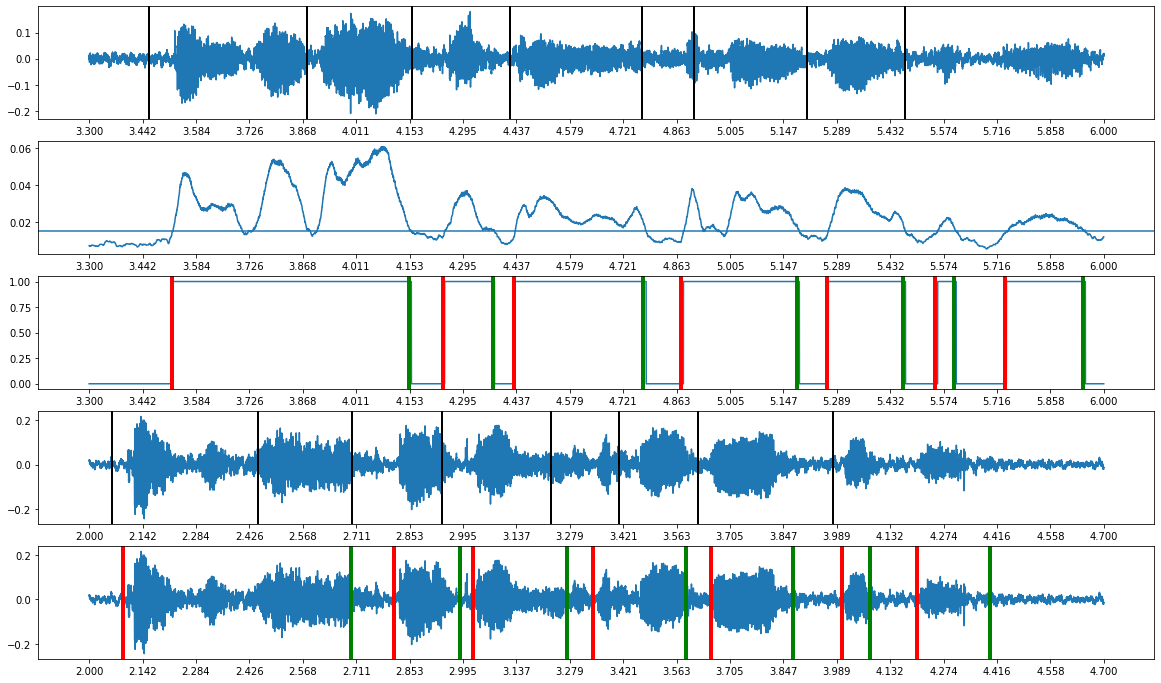

In [23]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 6
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7

timelst1 = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
timelst2 = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, timelst1 = timelst1, timelst2 = timelst2, input_min_pause = 30, threshold1=0.015)

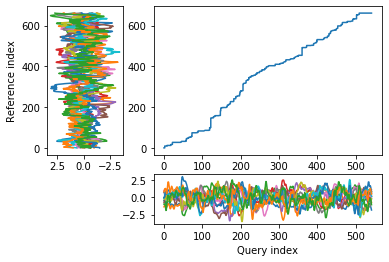

Overall normalized stretch =  0.8769701243458923
                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   3.51919   4.15185   4.24151   4.37601   4.43081   4.77454   
start in voice 2   1.83948   2.76605   2.95535   3.34889   3.43856   3.74244   
stretch           0.902969  0.879473  0.858471  0.804311  0.843379  0.735613   

                        7         8         9         10        11        12  \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   4.87417   5.18303   5.26273   5.46697   5.55166   5.60148   
start in voice 2    3.8072   4.20074   4.26052    4.5345   4.61919   4.68893   
stretch           0.856509  0.787767  0.842306  0.685072  0.941385  0.916769   

                        13  
seg                 speech  
start in voice 1   5.73598  
start in voice 2   4.79852  
stretch           0.951873  

DTW

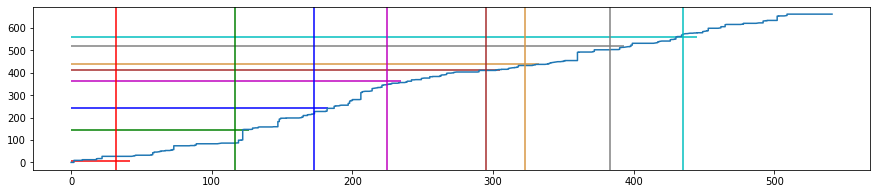

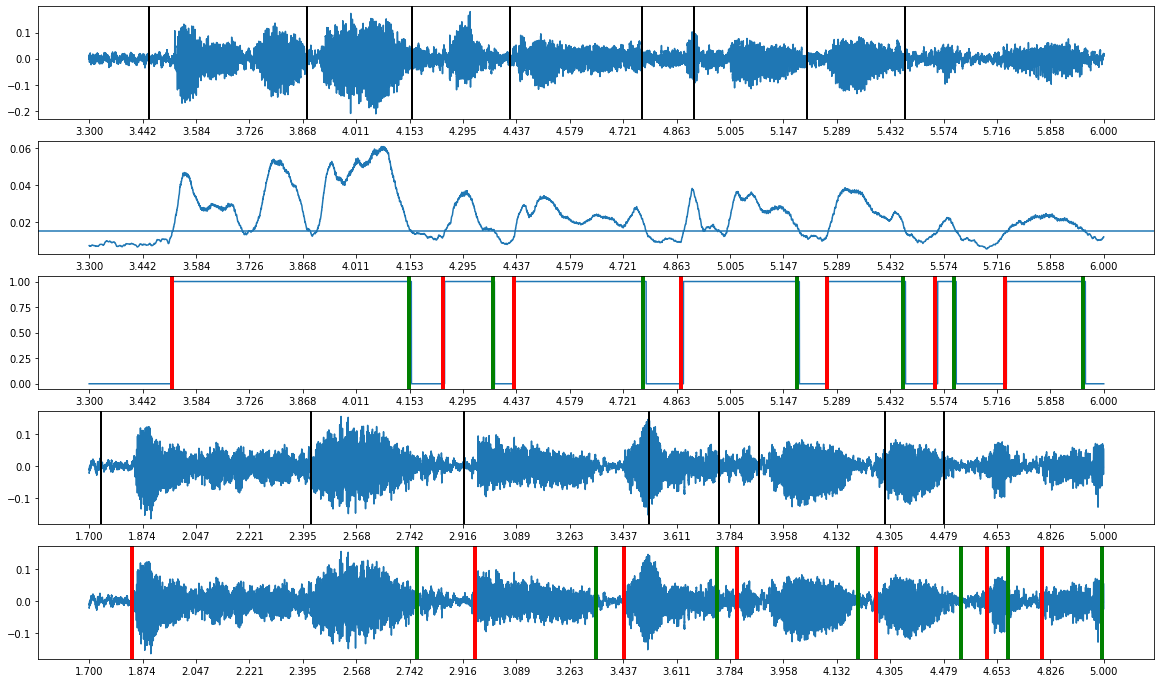

In [22]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 6
file2, seg2_1, seg2_2 = "02.wav", 1.7, 5

timelst1 = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
timelst2 = [1.74, 2.42, 2.92, 3.52, 3.75, 3.88, 4.29, 4.48]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, timelst1 = timelst1, timelst2 = timelst2, input_min_pause = 30, threshold1=0.015)

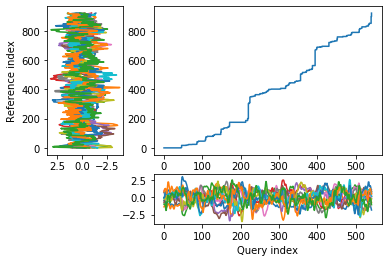

Overall normalized stretch =  0.9166086397579817
                       1        2         3         4         5         6   \
seg                speech    pause    speech     pause    speech     pause   
start in voice 1  3.51919  4.15185   4.24151   4.37601   4.43081   4.77454   
start in voice 2      1.4  2.13727   2.27177   2.33155   3.14354   3.40258   
stretch           0.88833        1  0.971459  0.974824  0.855975  0.906447   

                        7         8         9        10       11        12  \
seg                 speech     pause    speech    pause   speech     pause   
start in voice 1   4.87417   5.18303   5.26273  5.46697  5.55166   5.60148   
start in voice 2   3.42749   4.04022   4.20461  4.99668  5.11125     5.181   
stretch           0.876038  0.930724  0.978169  0.91161        1  0.897464   

                        13  
seg                 speech  
start in voice 1   5.73598  
start in voice 2   5.27066  
stretch           0.895228  

DTW distance =  2.91539

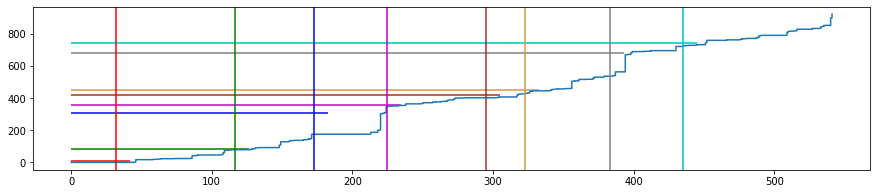

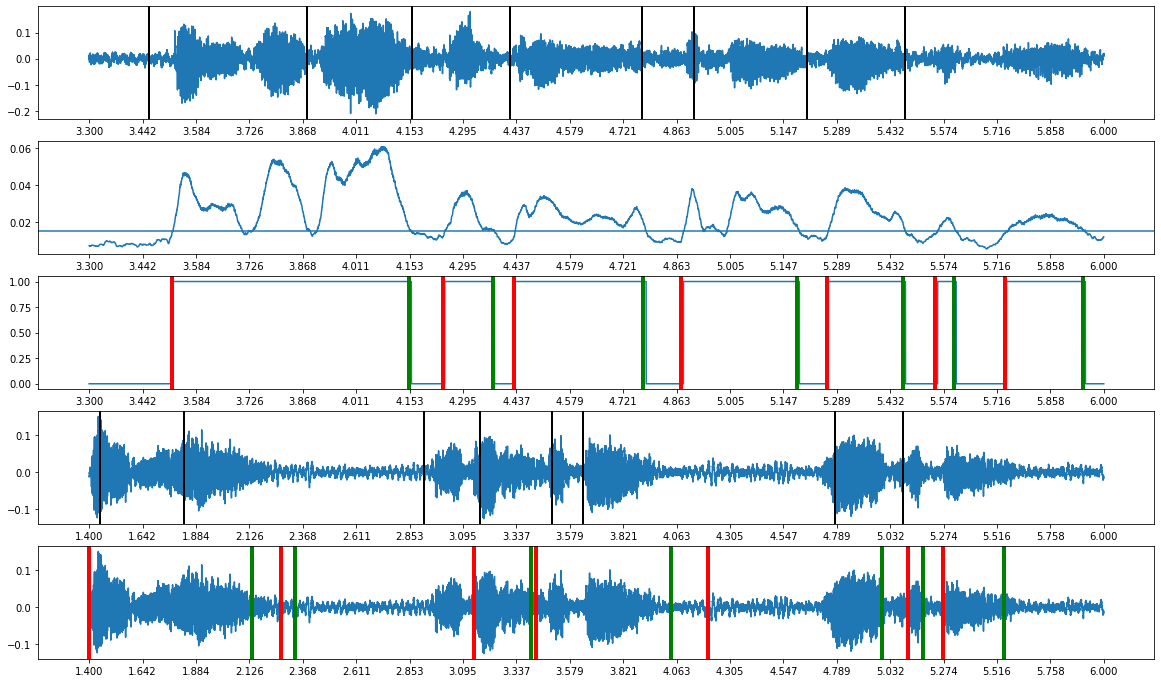

In [21]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 6
file2, seg2_1, seg2_2 = "05.wav", 1.4, 6

timelst1 = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] 
timelst2 = [1.45, 1.83, 2.92, 3.17, 3.5, 3.64, 4.78, 5.09]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, timelst1 = timelst1, timelst2 = timelst2, input_min_pause = 30, threshold1=0.015)

In [16]:
def compute_dtw(file1, file2, *args, **kwargs):
    
    num_of_mfcc = kwargs.get('num_of_mfcc', 13)
    alpha = kwargs.get('alpha', 1)

    x, sr1 = librosa.load(capstone_dir + "/py_converted/" + file1, sr=None)
    y, sr2 = librosa.load(capstone_dir + "/py_converted/" + file2, sr=None)

    fragment_x = x
    fragment_y = y

    mfcc1 = librosa.feature.mfcc(fragment_x, sr1, n_mfcc=num_of_mfcc, hop_length=int(hop_len_in_s*sr1))
    mfcc2 = librosa.feature.mfcc(fragment_y, sr2, n_mfcc=num_of_mfcc, hop_length=int(hop_len_in_s*sr2)) 

    # normalize each mfcc
    mfcc1_normal = normalize(mfcc1)
    mfcc2_normal = normalize(mfcc2)
    
    dtw_input1 = mfcc1_normal.T
    dtw_input2 = mfcc2_normal.T
    
    alignment = dtw(dtw_input1, dtw_input2, keep_internals=True, step_pattern = 'symmetric1', dist_method = 'cityblock')
    alignment.plot('threeway')
    
    theta = math.atan(1)  # angle of diagonal = length of y axis over length of x axis
    
    overall_stretch = 0
    overall_arclen = 0
    

    xs = alignment.index1
    ys = alignment.index2

    stretch = 0
    arclen = 0            

    for i in range(len(xs)-1):

        if i % alpha == 0:
            if xs[i+1]-xs[i] == 0:
                rho_i = math.pi/2
            else:
                rho_i = math.atan((ys[i+1]-ys[i]) / (xs[i+1]-xs[i]))

            dev_rho_i = deviation(rho_i, theta)
            stretch = stretch + dev_rho_i*math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
            overall_stretch = overall_stretch + stretch

        arclen = arclen + math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
        overall_arclen = overall_arclen + arclen            
        
    print_stretch_and_distance(alignment, num_of_mfcc, overall_stretch, overall_arclen)
    

# 01

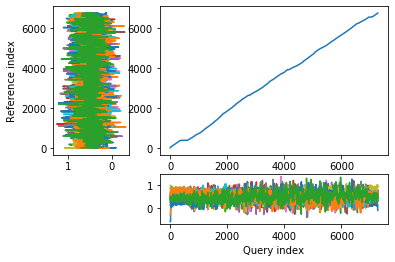

Stretch = 0.16

Distance  = 0.36


In [15]:
compute_dtw("01.wav", "01_1.wav") # normal vs normal

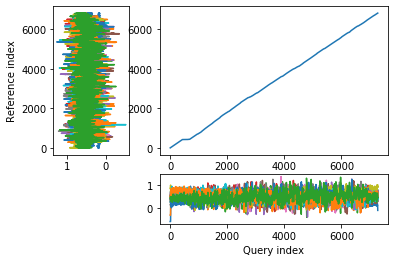

Stretch = 0.12

Distance  = 0.39


In [192]:
compute_dtw("01.wav", "01_2.wav") # normal vs normal

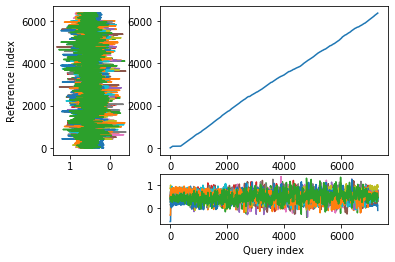

Stretch = 0.15

Distance  = 0.37


In [193]:
compute_dtw("01.wav", "01_3.wav") # normal vs normal

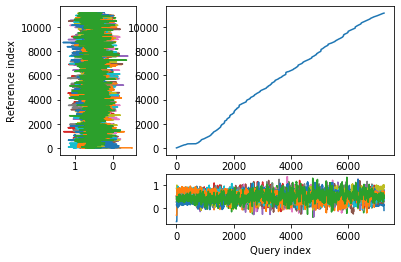

Stretch = 0.38

Distance  = 0.36


In [194]:
compute_dtw("01.wav", "02.wav") # normal vs slightly slow  

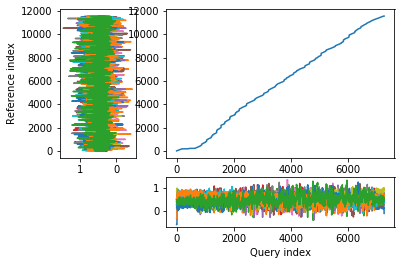

Stretch = 0.40

Distance  = 0.41


In [195]:
compute_dtw("01.wav", "05.wav") # normal vs short pauses

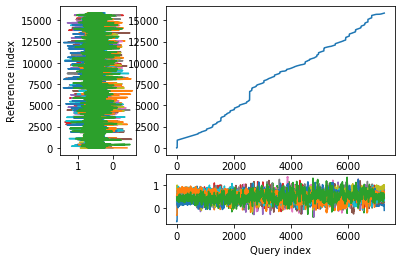

Stretch = 0.50

Distance  = 0.44


In [196]:
compute_dtw("01.wav", "pause_m01.wav") # normal vs repeat part of the word

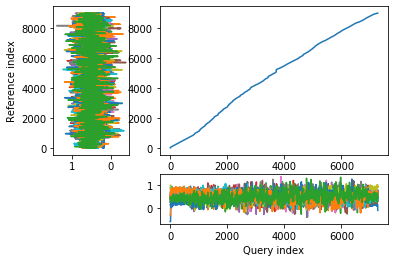

Stretch = 0.20

Distance  = 0.40


In [197]:
compute_dtw("01.wav", "02_1.wav") # normal vs slower

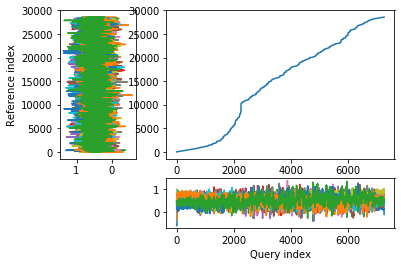

Stretch = 0.68

Distance  = 0.47


In [198]:
compute_dtw("01.wav", "long_w01.wav") # normal vs slower

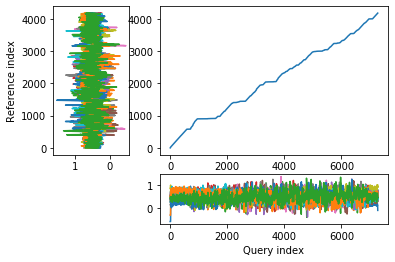

Stretch = 0.38

Distance  = 0.50


In [199]:
compute_dtw("01.wav", "repeat-syllable01.wav") # normal vs stutter

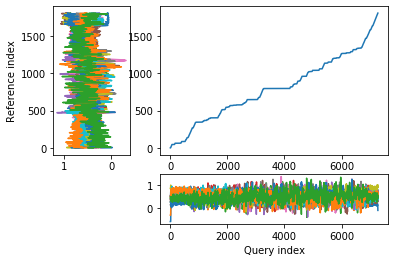

Stretch = 0.72

Distance  = 0.52


In [200]:
compute_dtw("01.wav", "torgo-healthy.wav") # completely different words

# 01_1

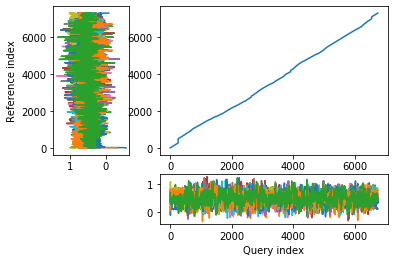

Stretch = 0.15

Distance  = 0.12


In [144]:
compute_dtw("01_1.wav", "01.wav")

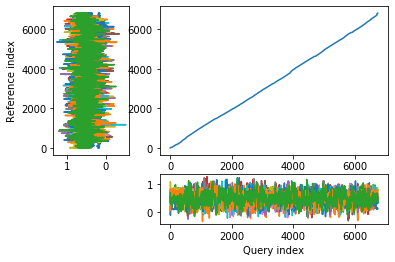

Stretch = 0.09

Distance  = 0.12


In [145]:
compute_dtw("01_1.wav", "01_2.wav") 

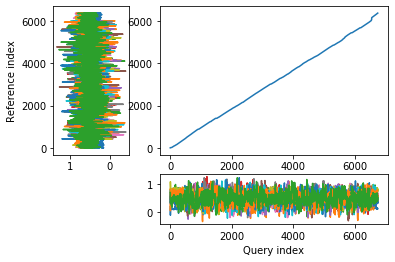

Stretch = 0.10

Distance  = 0.12


In [146]:
compute_dtw("01_1.wav", "01_3.wav")

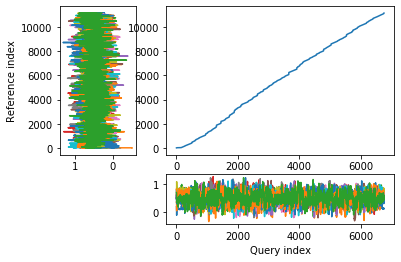

Stretch = 0.36

Distance  = 0.13


In [147]:
compute_dtw("01_1.wav", "02.wav")

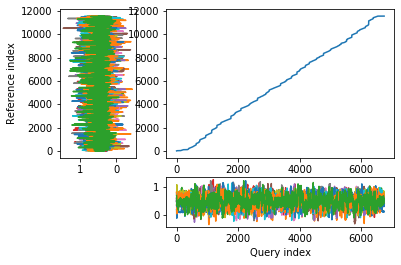

Stretch = 0.40

Distance  = 0.13


In [148]:
compute_dtw("01_1.wav", "05.wav")

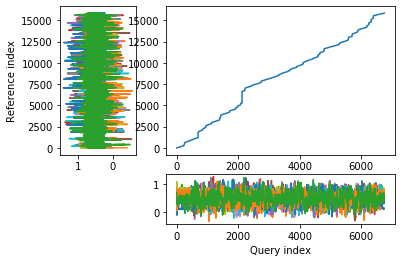

Stretch = 0.51

Distance  = 0.15


In [149]:
compute_dtw("01_1.wav", "pause_m01.wav")

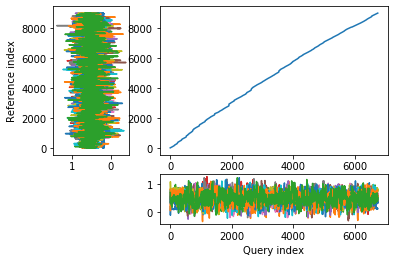

Stretch = 0.24

Distance  = 0.13


In [150]:
compute_dtw("01_1.wav", "02_1.wav")

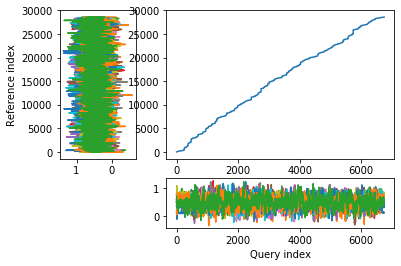

Stretch = 0.72

Distance  = 0.16


In [151]:
compute_dtw("01_1.wav", "long_w01.wav")

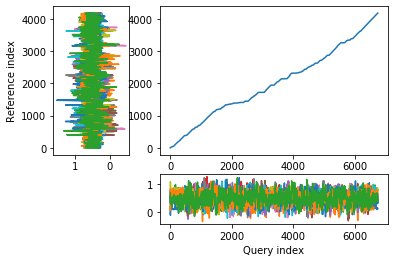

Stretch = 0.33

Distance  = 0.17


In [152]:
compute_dtw("01_1.wav", "repeat-syllable01.wav")

# 01_2

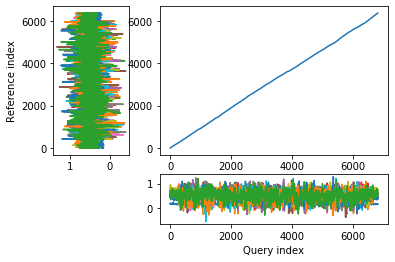

Stretch = 0.07

Distance  = 0.13


In [153]:
compute_dtw("01_2.wav", "01_3.wav")

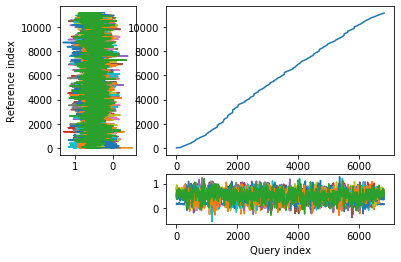

Stretch = 0.35

Distance  = 0.13


In [154]:
compute_dtw("01_2.wav", "02.wav")

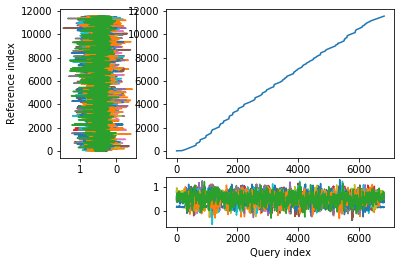

Stretch = 0.39

Distance  = 0.14


In [155]:
compute_dtw("01_2.wav", "05.wav")

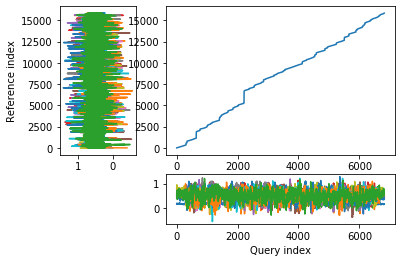

Stretch = 0.52

Distance  = 0.14


In [156]:
compute_dtw("01_2.wav", "pause_m01.wav")

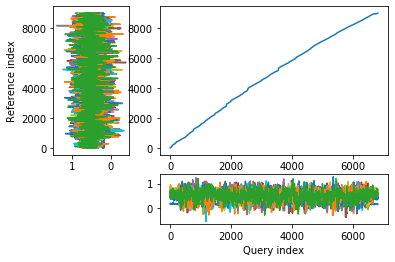

Stretch = 0.25

Distance  = 0.11


In [157]:
compute_dtw("01_2.wav", "02_1.wav")

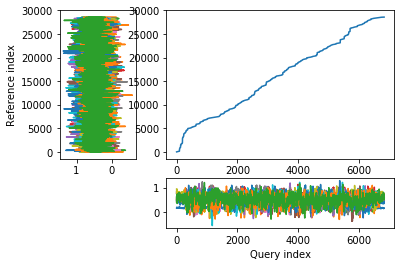

Stretch = 0.73

Distance  = 0.16


In [158]:
compute_dtw("01_2.wav", "long_w01.wav")

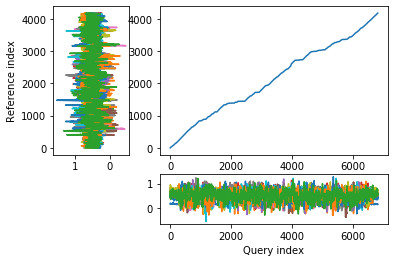

Stretch = 0.31

Distance  = 0.17


In [159]:
compute_dtw("01_2.wav", "repeat-syllable01.wav")

# 01_3

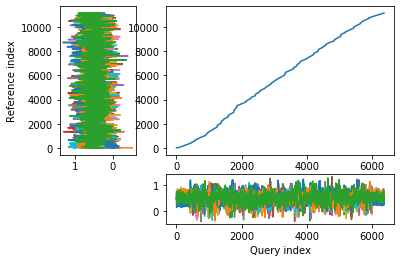

Stretch = 0.38

Distance  = 0.13


In [160]:
compute_dtw("01_3.wav", "02.wav")

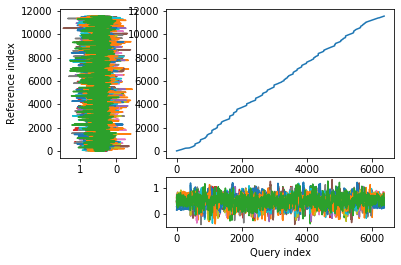

Stretch = 0.41

Distance  = 0.14


In [161]:
compute_dtw("01_3.wav", "05.wav")

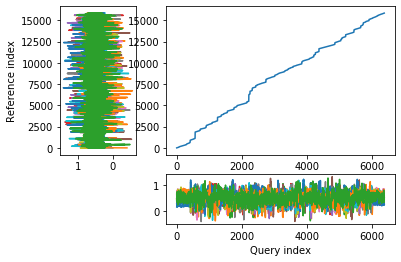

Stretch = 0.54

Distance  = 0.14


In [162]:
compute_dtw("01_3.wav", "pause_m01.wav")

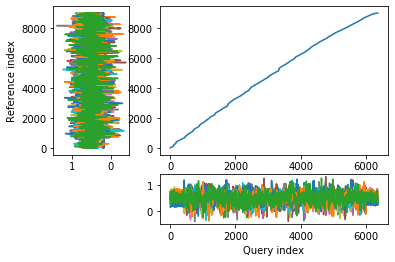

Stretch = 0.28

Distance  = 0.13


In [163]:
compute_dtw("01_3.wav", "02_1.wav")

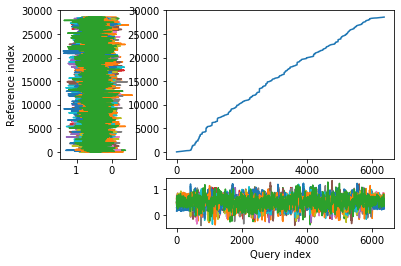

Stretch = 0.75

Distance  = 0.15


In [164]:
compute_dtw("01_3.wav", "long_w01.wav")

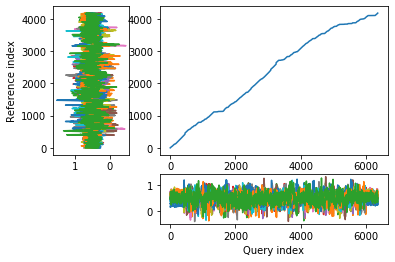

Stretch = 0.25

Distance  = 0.16


In [165]:
compute_dtw("01_3.wav", "repeat-syllable01.wav")

# 02

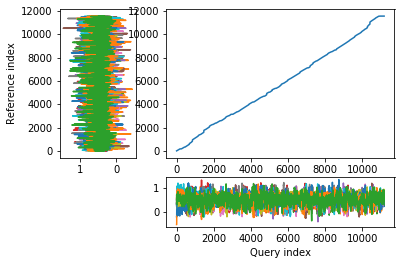

Stretch = 0.23

Distance  = 0.12


In [166]:
compute_dtw("02.wav", "05.wav")

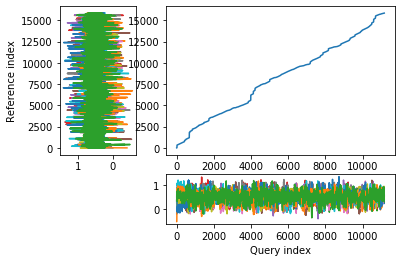

Stretch = 0.37

Distance  = 0.13


In [167]:
compute_dtw("02.wav", "pause_m01.wav")

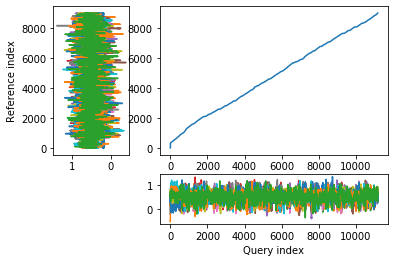

Stretch = 0.24

Distance  = 0.13


In [168]:
compute_dtw("02.wav", "02_1.wav")

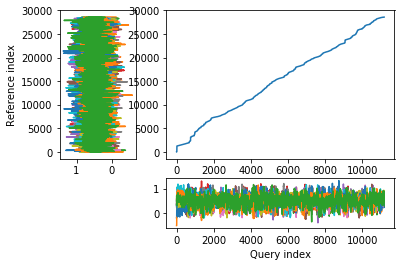

Stretch = 0.56

Distance  = 0.13


In [169]:
compute_dtw("02.wav", "long_w01.wav")

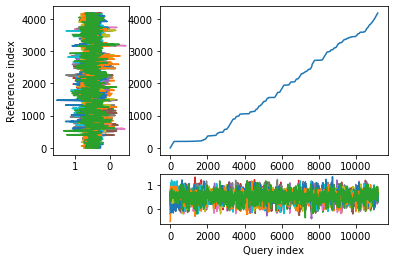

Stretch = 0.61

Distance  = 0.17


In [170]:
compute_dtw("02.wav", "repeat-syllable01.wav")

# 05

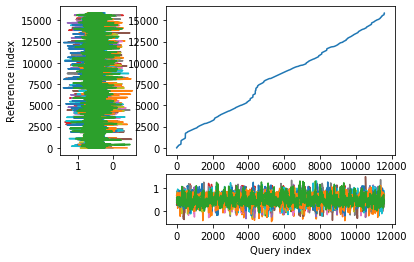

Stretch = 0.32

Distance  = 0.13


In [171]:
compute_dtw("05.wav", "pause_m01.wav")

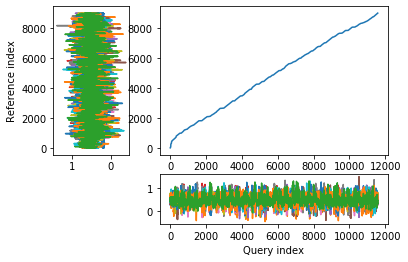

Stretch = 0.28

Distance  = 0.14


In [172]:
compute_dtw("05.wav", "02_1.wav")

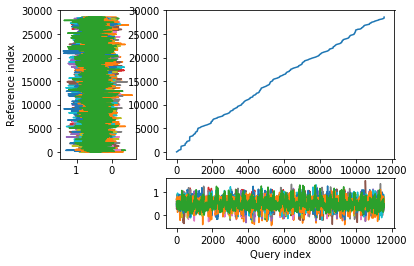

Stretch = 0.55

Distance  = 0.14


In [173]:
compute_dtw("05.wav", "long_w01.wav")

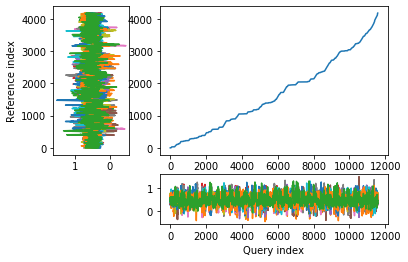

Stretch = 0.64

Distance  = 0.16


In [174]:
compute_dtw("05.wav", "repeat-syllable01.wav")

# pause_m01

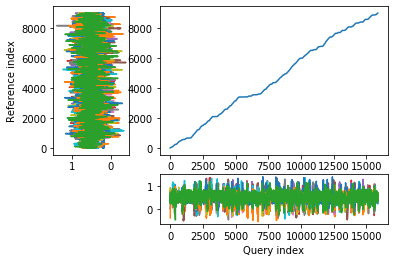

Stretch = 0.38

Distance  = 0.14


In [175]:
compute_dtw("pause_m01.wav", "02_1.wav")

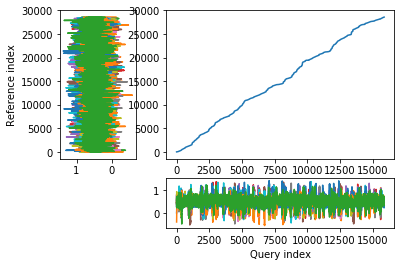

Stretch = 0.45

Distance  = 0.13


In [176]:
compute_dtw("pause_m01.wav", "long_w01.wav")

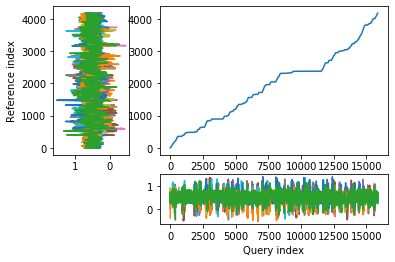

Stretch = 0.69

Distance  = 0.16


In [177]:
compute_dtw("pause_m01.wav", "repeat-syllable01.wav")

# 02_1

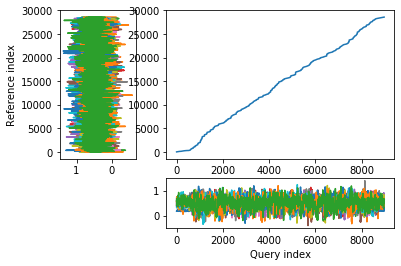

Stretch = 0.63

Distance  = 0.15


In [178]:
compute_dtw("02_1.wav", "long_w01.wav")

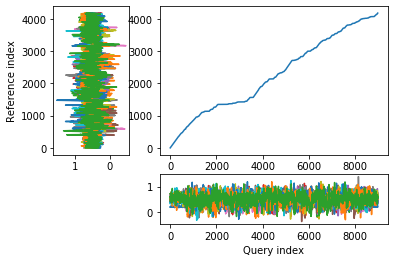

Stretch = 0.42

Distance  = 0.17


In [179]:
compute_dtw("02_1.wav", "repeat-syllable01.wav")

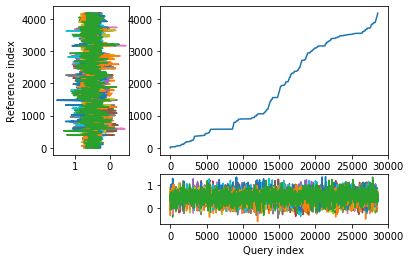

Stretch = 0.83

Distance  = 0.18


In [180]:
compute_dtw("long_w01.wav", "repeat-syllable01.wav")

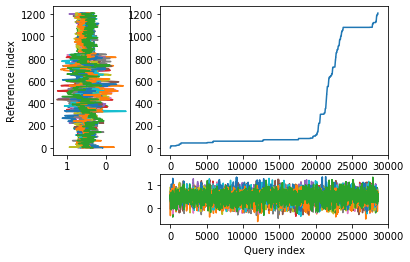

Stretch = 0.97

Distance  = 0.18


In [181]:
compute_dtw("long_w01.wav", "report-normal1.wav")

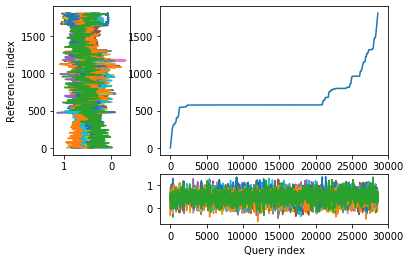

Stretch = 0.94

Distance  = 0.20


In [182]:
compute_dtw("long_w01.wav", "torgo-healthy.wav")